In [1]:
import torch
import pandas as pd
from collections import Counter
import music21
from torch import nn
import numpy as np
from music21 import converter, instrument, note, chord, stream

In [2]:
torch.cuda.is_available()

True

# Load data

In [3]:
df = pd.read_csv(r'D:\Documents\Music generation project\data\df\ff_music_df.csv')
df = df.dropna()
df.head()

,id,music
0,1,4.9 E2 4.9 4.9 4.9 4.9 4.9 4.9 4.9 11.4 4.9 11...
1,2,C5 E4 C2 C5 E4 C2 G4 G4 C5 C5 D5 10.2 B-1 D5 1...
2,3,0.4 0.4 0.5 0.5 0.4 0.4 0.2 C5 0.2 F5 G5 0.4 0...
4,5,F3 C4 4.9 E4 C4 2.5 E4 C4 9.0 E4 C4 F3 C4 4.9 ...
5,6,C6 A3 E4 C6 F4 E4 C6 A3 E4 C6 F4 E4 E5 A3 E4 E...


BPTTIterator (one of the Pytorch Iterator for NLP) accept only one example as input, so we need to create a string that will contains all our music with every notes and chors. 

In [4]:
mylist = df['music'].to_list()
mylist = [' '.join(str(i) for i in mylist)]
len(mylist)

1

In [5]:
from torchtext.data import Field, BPTTIterator, Dataset, Example

#prepare the field

tokenize = lambda x: x.split()

TEXT = Field(sequential = True, tokenize = tokenize, fix_length = None)

datafields = [("text",TEXT)]

#loading the dataset

train_examples = [Example.fromlist(mylist, datafields)] 
train_data = Dataset(train_examples, datafields) #define a dataset composed of examples along with its field

#build the vocab

TEXT.build_vocab(train_data)

vocab = TEXT.vocab

#create the iterator object

train_iter = BPTTIterator(train_data, batch_size=10, bptt_len=5)

#if bptt_len = 3:

#E2 4.9 11.4 -> 4.9 11.4 D3



## THE MODEL 

In [6]:
class LSTMClassifier(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size, dropout, embedding_dim, num_layers):
        super(LSTMClassifier, self).__init__()
        self.input_size = input_size
        self.num_layers = num_layers
        
        self.emb = nn.Embedding(input_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers = num_layers, dropout = dropout)
        self.fc = nn.Linear(self.input_size, output_size)
    
    def forward(self, x):
        emb = self.emb(x)
        lstm_out, state = self.lstm(emb)
        logits = self.fc(lstm_out)
        return  logits, state
    
    def initHidden(self, sequence_length):
        return (torch.zeros(self.num_layers, sequence_length, self.input_size).cuda(),
                torch.zeros(self.num_layers, sequence_length, self.input_size).cuda())
        

In [7]:
def train(model, iterator, criterion, epoch):
    total_loss, total_correct, total_prediction = 0.0, 0.0, 0.0
    model.train()
    
    for epoch in range(epoch):
    
        for batch, x in enumerate(iterator): 
            optimizer.zero_grad()
            
            batch_text = x.text.cuda()
            batch_target = x.target.cuda()

            result, (state_h, state_c) = model(batch_text)
            loss = criterion(result.view(-1, result.shape[-1]), batch_target.view(-1))
            
            loss.backward()
            optimizer.step()

            print({ 'epoch': epoch, 'batch': batch, 'loss': loss.item() })


In [8]:
from torch import optim

input_size = len(TEXT.vocab)
hidden_size = len(TEXT.vocab)
output_size= len(TEXT.vocab) #we want a probability for each note and chord
dropout = 0.4
embedding_dim = 128
num_layers = 3
epoch = 10

model = LSTMClassifier(input_size, hidden_size, output_size, dropout, embedding_dim, num_layers)
criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model.cuda()
criterion.cuda()

train(model, train_iter, criterion, epoch)


{'epoch': 0, 'batch': 0, 'loss': 5.881579399108887}
{'epoch': 0, 'batch': 1, 'loss': 5.869513034820557}
{'epoch': 0, 'batch': 2, 'loss': 5.848291397094727}
{'epoch': 0, 'batch': 3, 'loss': 5.847034454345703}
{'epoch': 0, 'batch': 4, 'loss': 5.810878753662109}
{'epoch': 0, 'batch': 5, 'loss': 5.8209123611450195}
{'epoch': 0, 'batch': 6, 'loss': 5.7431721687316895}
{'epoch': 0, 'batch': 7, 'loss': 5.676753044128418}
{'epoch': 0, 'batch': 8, 'loss': 5.728945732116699}
{'epoch': 0, 'batch': 9, 'loss': 5.66431999206543}
{'epoch': 0, 'batch': 10, 'loss': 5.5211029052734375}
{'epoch': 0, 'batch': 11, 'loss': 5.343369007110596}
{'epoch': 0, 'batch': 12, 'loss': 5.089434623718262}
{'epoch': 0, 'batch': 13, 'loss': 5.01082706451416}
{'epoch': 0, 'batch': 14, 'loss': 4.847682952880859}
{'epoch': 0, 'batch': 15, 'loss': 4.973459243774414}
{'epoch': 0, 'batch': 16, 'loss': 4.94527006149292}
{'epoch': 0, 'batch': 17, 'loss': 5.0933966636657715}
{'epoch': 0, 'batch': 18, 'loss': 4.806654930114746}
{'

{'epoch': 0, 'batch': 163, 'loss': 4.720751762390137}
{'epoch': 0, 'batch': 164, 'loss': 4.682153224945068}
{'epoch': 0, 'batch': 165, 'loss': 4.6574320793151855}
{'epoch': 0, 'batch': 166, 'loss': 4.474643707275391}
{'epoch': 0, 'batch': 167, 'loss': 4.659515857696533}
{'epoch': 0, 'batch': 168, 'loss': 4.518148899078369}
{'epoch': 0, 'batch': 169, 'loss': 4.754148006439209}
{'epoch': 0, 'batch': 170, 'loss': 4.763187885284424}
{'epoch': 0, 'batch': 171, 'loss': 4.757649898529053}
{'epoch': 0, 'batch': 172, 'loss': 4.69598913192749}
{'epoch': 0, 'batch': 173, 'loss': 4.481260299682617}
{'epoch': 0, 'batch': 174, 'loss': 4.417451858520508}
{'epoch': 0, 'batch': 175, 'loss': 4.687813758850098}
{'epoch': 0, 'batch': 176, 'loss': 4.691756725311279}
{'epoch': 0, 'batch': 177, 'loss': 4.402620315551758}
{'epoch': 0, 'batch': 178, 'loss': 4.561814785003662}
{'epoch': 0, 'batch': 179, 'loss': 4.503117561340332}
{'epoch': 0, 'batch': 180, 'loss': 4.304251194000244}
{'epoch': 0, 'batch': 181, '

{'epoch': 0, 'batch': 332, 'loss': 4.820578098297119}
{'epoch': 0, 'batch': 333, 'loss': 4.356601238250732}
{'epoch': 0, 'batch': 334, 'loss': 4.420975208282471}
{'epoch': 0, 'batch': 335, 'loss': 4.249106407165527}
{'epoch': 0, 'batch': 336, 'loss': 4.608698844909668}
{'epoch': 0, 'batch': 337, 'loss': 4.662430286407471}
{'epoch': 0, 'batch': 338, 'loss': 4.491433620452881}
{'epoch': 0, 'batch': 339, 'loss': 4.633126735687256}
{'epoch': 0, 'batch': 340, 'loss': 4.682689666748047}
{'epoch': 0, 'batch': 341, 'loss': 4.375720024108887}
{'epoch': 0, 'batch': 342, 'loss': 4.540560722351074}
{'epoch': 0, 'batch': 343, 'loss': 4.421857833862305}
{'epoch': 0, 'batch': 344, 'loss': 4.660849571228027}
{'epoch': 0, 'batch': 345, 'loss': 4.566177845001221}
{'epoch': 0, 'batch': 346, 'loss': 4.374176502227783}
{'epoch': 0, 'batch': 347, 'loss': 4.662084579467773}
{'epoch': 0, 'batch': 348, 'loss': 4.533629417419434}
{'epoch': 0, 'batch': 349, 'loss': 4.11363410949707}
{'epoch': 0, 'batch': 350, 'l

{'epoch': 0, 'batch': 502, 'loss': 4.232626914978027}
{'epoch': 0, 'batch': 503, 'loss': 4.1783037185668945}
{'epoch': 0, 'batch': 504, 'loss': 4.484576225280762}
{'epoch': 0, 'batch': 505, 'loss': 4.062310218811035}
{'epoch': 0, 'batch': 506, 'loss': 3.784456253051758}
{'epoch': 0, 'batch': 507, 'loss': 3.9995713233947754}
{'epoch': 0, 'batch': 508, 'loss': 3.803922414779663}
{'epoch': 0, 'batch': 509, 'loss': 4.181034564971924}
{'epoch': 0, 'batch': 510, 'loss': 4.216160297393799}
{'epoch': 0, 'batch': 511, 'loss': 3.8141069412231445}
{'epoch': 0, 'batch': 512, 'loss': 3.9329721927642822}
{'epoch': 0, 'batch': 513, 'loss': 4.05368185043335}
{'epoch': 0, 'batch': 514, 'loss': 3.798954486846924}
{'epoch': 0, 'batch': 515, 'loss': 4.183607578277588}
{'epoch': 0, 'batch': 516, 'loss': 4.1280741691589355}
{'epoch': 0, 'batch': 517, 'loss': 4.004660129547119}
{'epoch': 0, 'batch': 518, 'loss': 3.995889902114868}
{'epoch': 0, 'batch': 519, 'loss': 4.061018943786621}
{'epoch': 0, 'batch': 52

{'epoch': 0, 'batch': 671, 'loss': 3.6868042945861816}
{'epoch': 0, 'batch': 672, 'loss': 3.5335886478424072}
{'epoch': 0, 'batch': 673, 'loss': 3.7340972423553467}
{'epoch': 0, 'batch': 674, 'loss': 3.6879098415374756}
{'epoch': 0, 'batch': 675, 'loss': 3.4473254680633545}
{'epoch': 0, 'batch': 676, 'loss': 3.645158052444458}
{'epoch': 0, 'batch': 677, 'loss': 3.597694158554077}
{'epoch': 0, 'batch': 678, 'loss': 3.6982529163360596}
{'epoch': 0, 'batch': 679, 'loss': 3.5840277671813965}
{'epoch': 0, 'batch': 680, 'loss': 3.5128772258758545}
{'epoch': 0, 'batch': 681, 'loss': 3.6670033931732178}
{'epoch': 0, 'batch': 682, 'loss': 3.7240042686462402}
{'epoch': 0, 'batch': 683, 'loss': 3.698554277420044}
{'epoch': 0, 'batch': 684, 'loss': 3.964738130569458}
{'epoch': 0, 'batch': 685, 'loss': 3.7977981567382812}
{'epoch': 0, 'batch': 686, 'loss': 3.904766321182251}
{'epoch': 0, 'batch': 687, 'loss': 3.7407779693603516}
{'epoch': 0, 'batch': 688, 'loss': 3.6282925605773926}
{'epoch': 0, 'b

{'epoch': 0, 'batch': 841, 'loss': 4.417086124420166}
{'epoch': 0, 'batch': 842, 'loss': 4.3101887702941895}
{'epoch': 0, 'batch': 843, 'loss': 4.021329402923584}
{'epoch': 0, 'batch': 844, 'loss': 3.9744482040405273}
{'epoch': 0, 'batch': 845, 'loss': 4.667047500610352}
{'epoch': 0, 'batch': 846, 'loss': 4.368978977203369}
{'epoch': 0, 'batch': 847, 'loss': 4.891173839569092}
{'epoch': 0, 'batch': 848, 'loss': 4.874367713928223}
{'epoch': 0, 'batch': 849, 'loss': 4.394863128662109}
{'epoch': 0, 'batch': 850, 'loss': 3.911346435546875}
{'epoch': 0, 'batch': 851, 'loss': 4.006077289581299}
{'epoch': 0, 'batch': 852, 'loss': 4.410388946533203}
{'epoch': 0, 'batch': 853, 'loss': 4.62777042388916}
{'epoch': 0, 'batch': 854, 'loss': 4.777055740356445}
{'epoch': 0, 'batch': 855, 'loss': 4.158291816711426}
{'epoch': 0, 'batch': 856, 'loss': 4.479197978973389}
{'epoch': 0, 'batch': 857, 'loss': 5.106116771697998}
{'epoch': 0, 'batch': 858, 'loss': 4.778687000274658}
{'epoch': 0, 'batch': 859, 

{'epoch': 0, 'batch': 1011, 'loss': 3.957742929458618}
{'epoch': 0, 'batch': 1012, 'loss': 3.88430118560791}
{'epoch': 0, 'batch': 1013, 'loss': 4.0014328956604}
{'epoch': 0, 'batch': 1014, 'loss': 3.9969732761383057}
{'epoch': 0, 'batch': 1015, 'loss': 4.009873867034912}
{'epoch': 0, 'batch': 1016, 'loss': 4.28022575378418}
{'epoch': 0, 'batch': 1017, 'loss': 3.998983383178711}
{'epoch': 0, 'batch': 1018, 'loss': 3.8268728256225586}
{'epoch': 0, 'batch': 1019, 'loss': 4.156063556671143}
{'epoch': 0, 'batch': 1020, 'loss': 4.585115909576416}
{'epoch': 0, 'batch': 1021, 'loss': 4.342691421508789}
{'epoch': 0, 'batch': 1022, 'loss': 4.314214706420898}
{'epoch': 0, 'batch': 1023, 'loss': 4.573568344116211}
{'epoch': 0, 'batch': 1024, 'loss': 4.346374034881592}
{'epoch': 0, 'batch': 1025, 'loss': 4.414145469665527}
{'epoch': 0, 'batch': 1026, 'loss': 4.487698078155518}
{'epoch': 0, 'batch': 1027, 'loss': 3.9893133640289307}
{'epoch': 0, 'batch': 1028, 'loss': 4.1250810623168945}
{'epoch': 

{'epoch': 1, 'batch': 49, 'loss': 3.7514538764953613}
{'epoch': 1, 'batch': 50, 'loss': 3.719618797302246}
{'epoch': 1, 'batch': 51, 'loss': 3.7607388496398926}
{'epoch': 1, 'batch': 52, 'loss': 3.6177823543548584}
{'epoch': 1, 'batch': 53, 'loss': 3.6956350803375244}
{'epoch': 1, 'batch': 54, 'loss': 3.6465234756469727}
{'epoch': 1, 'batch': 55, 'loss': 3.9107816219329834}
{'epoch': 1, 'batch': 56, 'loss': 3.69419527053833}
{'epoch': 1, 'batch': 57, 'loss': 3.5885958671569824}
{'epoch': 1, 'batch': 58, 'loss': 3.952610969543457}
{'epoch': 1, 'batch': 59, 'loss': 3.8377273082733154}
{'epoch': 1, 'batch': 60, 'loss': 3.4728493690490723}
{'epoch': 1, 'batch': 61, 'loss': 4.122373104095459}
{'epoch': 1, 'batch': 62, 'loss': 4.149528980255127}
{'epoch': 1, 'batch': 63, 'loss': 4.196473598480225}
{'epoch': 1, 'batch': 64, 'loss': 4.105412483215332}
{'epoch': 1, 'batch': 65, 'loss': 3.9419562816619873}
{'epoch': 1, 'batch': 66, 'loss': 3.5096960067749023}
{'epoch': 1, 'batch': 67, 'loss': 3.

{'epoch': 1, 'batch': 218, 'loss': 3.4524099826812744}
{'epoch': 1, 'batch': 219, 'loss': 3.7263894081115723}
{'epoch': 1, 'batch': 220, 'loss': 3.805894374847412}
{'epoch': 1, 'batch': 221, 'loss': 3.893845558166504}
{'epoch': 1, 'batch': 222, 'loss': 3.9571921825408936}
{'epoch': 1, 'batch': 223, 'loss': 3.5171356201171875}
{'epoch': 1, 'batch': 224, 'loss': 3.8313958644866943}
{'epoch': 1, 'batch': 225, 'loss': 3.6616010665893555}
{'epoch': 1, 'batch': 226, 'loss': 4.410033226013184}
{'epoch': 1, 'batch': 227, 'loss': 4.076775074005127}
{'epoch': 1, 'batch': 228, 'loss': 3.9850282669067383}
{'epoch': 1, 'batch': 229, 'loss': 4.184902667999268}
{'epoch': 1, 'batch': 230, 'loss': 4.090241432189941}
{'epoch': 1, 'batch': 231, 'loss': 4.095490455627441}
{'epoch': 1, 'batch': 232, 'loss': 4.61622428894043}
{'epoch': 1, 'batch': 233, 'loss': 3.763461112976074}
{'epoch': 1, 'batch': 234, 'loss': 3.7942235469818115}
{'epoch': 1, 'batch': 235, 'loss': 3.8424901962280273}
{'epoch': 1, 'batch'

{'epoch': 1, 'batch': 388, 'loss': 3.8375680446624756}
{'epoch': 1, 'batch': 389, 'loss': 3.7916088104248047}
{'epoch': 1, 'batch': 390, 'loss': 3.4380292892456055}
{'epoch': 1, 'batch': 391, 'loss': 3.7958898544311523}
{'epoch': 1, 'batch': 392, 'loss': 3.697432518005371}
{'epoch': 1, 'batch': 393, 'loss': 3.749061346054077}
{'epoch': 1, 'batch': 394, 'loss': 3.777864933013916}
{'epoch': 1, 'batch': 395, 'loss': 3.535179376602173}
{'epoch': 1, 'batch': 396, 'loss': 3.8302340507507324}
{'epoch': 1, 'batch': 397, 'loss': 3.9481678009033203}
{'epoch': 1, 'batch': 398, 'loss': 4.044162273406982}
{'epoch': 1, 'batch': 399, 'loss': 4.119653224945068}
{'epoch': 1, 'batch': 400, 'loss': 4.384171009063721}
{'epoch': 1, 'batch': 401, 'loss': 3.790508985519409}
{'epoch': 1, 'batch': 402, 'loss': 3.6693994998931885}
{'epoch': 1, 'batch': 403, 'loss': 4.042426586151123}
{'epoch': 1, 'batch': 404, 'loss': 3.8319737911224365}
{'epoch': 1, 'batch': 405, 'loss': 3.9765825271606445}
{'epoch': 1, 'batch

{'epoch': 1, 'batch': 558, 'loss': 4.016732215881348}
{'epoch': 1, 'batch': 559, 'loss': 4.181009292602539}
{'epoch': 1, 'batch': 560, 'loss': 4.313621997833252}
{'epoch': 1, 'batch': 561, 'loss': 4.363733768463135}
{'epoch': 1, 'batch': 562, 'loss': 4.261155128479004}
{'epoch': 1, 'batch': 563, 'loss': 4.353679180145264}
{'epoch': 1, 'batch': 564, 'loss': 4.246281623840332}
{'epoch': 1, 'batch': 565, 'loss': 4.100334167480469}
{'epoch': 1, 'batch': 566, 'loss': 4.313739776611328}
{'epoch': 1, 'batch': 567, 'loss': 4.189416408538818}
{'epoch': 1, 'batch': 568, 'loss': 3.7700562477111816}
{'epoch': 1, 'batch': 569, 'loss': 4.123579025268555}
{'epoch': 1, 'batch': 570, 'loss': 4.1662468910217285}
{'epoch': 1, 'batch': 571, 'loss': 3.8860764503479004}
{'epoch': 1, 'batch': 572, 'loss': 3.682647705078125}
{'epoch': 1, 'batch': 573, 'loss': 3.4786171913146973}
{'epoch': 1, 'batch': 574, 'loss': 3.8612706661224365}
{'epoch': 1, 'batch': 575, 'loss': 3.895024061203003}
{'epoch': 1, 'batch': 5

{'epoch': 1, 'batch': 727, 'loss': 3.592041015625}
{'epoch': 1, 'batch': 728, 'loss': 3.875387191772461}
{'epoch': 1, 'batch': 729, 'loss': 2.896024465560913}
{'epoch': 1, 'batch': 730, 'loss': 3.4750685691833496}
{'epoch': 1, 'batch': 731, 'loss': 3.1731884479522705}
{'epoch': 1, 'batch': 732, 'loss': 3.0174977779388428}
{'epoch': 1, 'batch': 733, 'loss': 3.352546453475952}
{'epoch': 1, 'batch': 734, 'loss': 3.3629980087280273}
{'epoch': 1, 'batch': 735, 'loss': 3.768817186355591}
{'epoch': 1, 'batch': 736, 'loss': 4.062690258026123}
{'epoch': 1, 'batch': 737, 'loss': 3.8773605823516846}
{'epoch': 1, 'batch': 738, 'loss': 4.258035659790039}
{'epoch': 1, 'batch': 739, 'loss': 3.721287488937378}
{'epoch': 1, 'batch': 740, 'loss': 3.477876663208008}
{'epoch': 1, 'batch': 741, 'loss': 3.2266082763671875}
{'epoch': 1, 'batch': 742, 'loss': 3.1606404781341553}
{'epoch': 1, 'batch': 743, 'loss': 3.065376043319702}
{'epoch': 1, 'batch': 744, 'loss': 3.624234199523926}
{'epoch': 1, 'batch': 74

{'epoch': 1, 'batch': 895, 'loss': 3.885439157485962}
{'epoch': 1, 'batch': 896, 'loss': 3.4390430450439453}
{'epoch': 1, 'batch': 897, 'loss': 3.1439695358276367}
{'epoch': 1, 'batch': 898, 'loss': 3.500608444213867}
{'epoch': 1, 'batch': 899, 'loss': 3.1234219074249268}
{'epoch': 1, 'batch': 900, 'loss': 3.5273187160491943}
{'epoch': 1, 'batch': 901, 'loss': 3.261079788208008}
{'epoch': 1, 'batch': 902, 'loss': 3.4244725704193115}
{'epoch': 1, 'batch': 903, 'loss': 3.395970106124878}
{'epoch': 1, 'batch': 904, 'loss': 3.797877788543701}
{'epoch': 1, 'batch': 905, 'loss': 3.4499006271362305}
{'epoch': 1, 'batch': 906, 'loss': 3.3066136837005615}
{'epoch': 1, 'batch': 907, 'loss': 3.107185125350952}
{'epoch': 1, 'batch': 908, 'loss': 3.792910575866699}
{'epoch': 1, 'batch': 909, 'loss': 3.5337488651275635}
{'epoch': 1, 'batch': 910, 'loss': 3.790493965148926}
{'epoch': 1, 'batch': 911, 'loss': 3.681429386138916}
{'epoch': 1, 'batch': 912, 'loss': 3.6814236640930176}
{'epoch': 1, 'batch

{'epoch': 1, 'batch': 1065, 'loss': 3.4072675704956055}
{'epoch': 1, 'batch': 1066, 'loss': 3.581528425216675}
{'epoch': 1, 'batch': 1067, 'loss': 3.74090576171875}
{'epoch': 1, 'batch': 1068, 'loss': 3.8960421085357666}
{'epoch': 1, 'batch': 1069, 'loss': 3.8545050621032715}
{'epoch': 1, 'batch': 1070, 'loss': 3.8439462184906006}
{'epoch': 1, 'batch': 1071, 'loss': 3.29121732711792}
{'epoch': 1, 'batch': 1072, 'loss': 3.522261619567871}
{'epoch': 1, 'batch': 1073, 'loss': 3.6694860458374023}
{'epoch': 1, 'batch': 1074, 'loss': 3.7306456565856934}
{'epoch': 1, 'batch': 1075, 'loss': 3.7016477584838867}
{'epoch': 1, 'batch': 1076, 'loss': 3.9052796363830566}
{'epoch': 1, 'batch': 1077, 'loss': 3.885970115661621}
{'epoch': 1, 'batch': 1078, 'loss': 3.6760165691375732}
{'epoch': 1, 'batch': 1079, 'loss': 4.058771133422852}
{'epoch': 1, 'batch': 1080, 'loss': 3.6022772789001465}
{'epoch': 1, 'batch': 1081, 'loss': 3.5366203784942627}
{'epoch': 1, 'batch': 1082, 'loss': 3.9811389446258545}


{'epoch': 2, 'batch': 104, 'loss': 3.9434802532196045}
{'epoch': 2, 'batch': 105, 'loss': 3.651629686355591}
{'epoch': 2, 'batch': 106, 'loss': 3.406052350997925}
{'epoch': 2, 'batch': 107, 'loss': 3.5176174640655518}
{'epoch': 2, 'batch': 108, 'loss': 4.034913539886475}
{'epoch': 2, 'batch': 109, 'loss': 3.746936082839966}
{'epoch': 2, 'batch': 110, 'loss': 3.879868507385254}
{'epoch': 2, 'batch': 111, 'loss': 3.9035158157348633}
{'epoch': 2, 'batch': 112, 'loss': 3.963155746459961}
{'epoch': 2, 'batch': 113, 'loss': 4.1432271003723145}
{'epoch': 2, 'batch': 114, 'loss': 4.054039478302002}
{'epoch': 2, 'batch': 115, 'loss': 4.137327671051025}
{'epoch': 2, 'batch': 116, 'loss': 3.820805311203003}
{'epoch': 2, 'batch': 117, 'loss': 3.5697765350341797}
{'epoch': 2, 'batch': 118, 'loss': 3.6152868270874023}
{'epoch': 2, 'batch': 119, 'loss': 3.7271947860717773}
{'epoch': 2, 'batch': 120, 'loss': 4.005283355712891}
{'epoch': 2, 'batch': 121, 'loss': 3.6752941608428955}
{'epoch': 2, 'batch'

{'epoch': 2, 'batch': 272, 'loss': 4.06288480758667}
{'epoch': 2, 'batch': 273, 'loss': 4.443014621734619}
{'epoch': 2, 'batch': 274, 'loss': 3.9172492027282715}
{'epoch': 2, 'batch': 275, 'loss': 3.9418063163757324}
{'epoch': 2, 'batch': 276, 'loss': 3.4243967533111572}
{'epoch': 2, 'batch': 277, 'loss': 3.9953503608703613}
{'epoch': 2, 'batch': 278, 'loss': 3.8441011905670166}
{'epoch': 2, 'batch': 279, 'loss': 3.389939308166504}
{'epoch': 2, 'batch': 280, 'loss': 3.520611524581909}
{'epoch': 2, 'batch': 281, 'loss': 3.5576157569885254}
{'epoch': 2, 'batch': 282, 'loss': 3.3782286643981934}
{'epoch': 2, 'batch': 283, 'loss': 3.6297287940979004}
{'epoch': 2, 'batch': 284, 'loss': 3.5103795528411865}
{'epoch': 2, 'batch': 285, 'loss': 3.619727373123169}
{'epoch': 2, 'batch': 286, 'loss': 3.8843085765838623}
{'epoch': 2, 'batch': 287, 'loss': 3.587643623352051}
{'epoch': 2, 'batch': 288, 'loss': 3.697361946105957}
{'epoch': 2, 'batch': 289, 'loss': 3.439692974090576}
{'epoch': 2, 'batch

{'epoch': 2, 'batch': 442, 'loss': 3.1510720252990723}
{'epoch': 2, 'batch': 443, 'loss': 3.239772319793701}
{'epoch': 2, 'batch': 444, 'loss': 3.515763282775879}
{'epoch': 2, 'batch': 445, 'loss': 3.2336690425872803}
{'epoch': 2, 'batch': 446, 'loss': 3.514894485473633}
{'epoch': 2, 'batch': 447, 'loss': 3.026588201522827}
{'epoch': 2, 'batch': 448, 'loss': 3.500591516494751}
{'epoch': 2, 'batch': 449, 'loss': 3.343001365661621}
{'epoch': 2, 'batch': 450, 'loss': 2.9349184036254883}
{'epoch': 2, 'batch': 451, 'loss': 3.384171962738037}
{'epoch': 2, 'batch': 452, 'loss': 3.1138298511505127}
{'epoch': 2, 'batch': 453, 'loss': 3.23325252532959}
{'epoch': 2, 'batch': 454, 'loss': 3.1828014850616455}
{'epoch': 2, 'batch': 455, 'loss': 3.1993067264556885}
{'epoch': 2, 'batch': 456, 'loss': 3.1466338634490967}
{'epoch': 2, 'batch': 457, 'loss': 3.4472150802612305}
{'epoch': 2, 'batch': 458, 'loss': 3.372342586517334}
{'epoch': 2, 'batch': 459, 'loss': 3.1603121757507324}
{'epoch': 2, 'batch'

{'epoch': 2, 'batch': 611, 'loss': 3.569344997406006}
{'epoch': 2, 'batch': 612, 'loss': 3.635497808456421}
{'epoch': 2, 'batch': 613, 'loss': 3.5157358646392822}
{'epoch': 2, 'batch': 614, 'loss': 3.300067663192749}
{'epoch': 2, 'batch': 615, 'loss': 3.117180824279785}
{'epoch': 2, 'batch': 616, 'loss': 2.9258251190185547}
{'epoch': 2, 'batch': 617, 'loss': 3.424734592437744}
{'epoch': 2, 'batch': 618, 'loss': 3.425293207168579}
{'epoch': 2, 'batch': 619, 'loss': 3.610247850418091}
{'epoch': 2, 'batch': 620, 'loss': 3.6169328689575195}
{'epoch': 2, 'batch': 621, 'loss': 3.760913610458374}
{'epoch': 2, 'batch': 622, 'loss': 3.2910337448120117}
{'epoch': 2, 'batch': 623, 'loss': 3.8225302696228027}
{'epoch': 2, 'batch': 624, 'loss': 3.6268246173858643}
{'epoch': 2, 'batch': 625, 'loss': 3.6923160552978516}
{'epoch': 2, 'batch': 626, 'loss': 3.4072329998016357}
{'epoch': 2, 'batch': 627, 'loss': 3.3669207096099854}
{'epoch': 2, 'batch': 628, 'loss': 3.4902727603912354}
{'epoch': 2, 'batc

{'epoch': 2, 'batch': 781, 'loss': 3.6270785331726074}
{'epoch': 2, 'batch': 782, 'loss': 3.5897557735443115}
{'epoch': 2, 'batch': 783, 'loss': 3.808753728866577}
{'epoch': 2, 'batch': 784, 'loss': 3.8178625106811523}
{'epoch': 2, 'batch': 785, 'loss': 2.9666855335235596}
{'epoch': 2, 'batch': 786, 'loss': 3.524725914001465}
{'epoch': 2, 'batch': 787, 'loss': 3.291604995727539}
{'epoch': 2, 'batch': 788, 'loss': 3.4006659984588623}
{'epoch': 2, 'batch': 789, 'loss': 3.831491470336914}
{'epoch': 2, 'batch': 790, 'loss': 3.635139226913452}
{'epoch': 2, 'batch': 791, 'loss': 3.320481300354004}
{'epoch': 2, 'batch': 792, 'loss': 4.067330837249756}
{'epoch': 2, 'batch': 793, 'loss': 4.17280387878418}
{'epoch': 2, 'batch': 794, 'loss': 4.009025573730469}
{'epoch': 2, 'batch': 795, 'loss': 4.183111190795898}
{'epoch': 2, 'batch': 796, 'loss': 3.883732318878174}
{'epoch': 2, 'batch': 797, 'loss': 4.181948184967041}
{'epoch': 2, 'batch': 798, 'loss': 3.424713373184204}
{'epoch': 2, 'batch': 79

{'epoch': 2, 'batch': 951, 'loss': 3.3741676807403564}
{'epoch': 2, 'batch': 952, 'loss': 3.5500500202178955}
{'epoch': 2, 'batch': 953, 'loss': 3.5780298709869385}
{'epoch': 2, 'batch': 954, 'loss': 3.4028351306915283}
{'epoch': 2, 'batch': 955, 'loss': 3.9590771198272705}
{'epoch': 2, 'batch': 956, 'loss': 3.4544074535369873}
{'epoch': 2, 'batch': 957, 'loss': 3.516629934310913}
{'epoch': 2, 'batch': 958, 'loss': 3.593991994857788}
{'epoch': 2, 'batch': 959, 'loss': 3.885072946548462}
{'epoch': 2, 'batch': 960, 'loss': 3.6717255115509033}
{'epoch': 2, 'batch': 961, 'loss': 3.641875982284546}
{'epoch': 2, 'batch': 962, 'loss': 3.455691337585449}
{'epoch': 2, 'batch': 963, 'loss': 3.462876081466675}
{'epoch': 2, 'batch': 964, 'loss': 3.347017765045166}
{'epoch': 2, 'batch': 965, 'loss': 3.5192983150482178}
{'epoch': 2, 'batch': 966, 'loss': 3.2691071033477783}
{'epoch': 2, 'batch': 967, 'loss': 3.7487668991088867}
{'epoch': 2, 'batch': 968, 'loss': 3.0506157875061035}
{'epoch': 2, 'bat

{'epoch': 2, 'batch': 1120, 'loss': 3.2020773887634277}
{'epoch': 2, 'batch': 1121, 'loss': 3.6366729736328125}
{'epoch': 2, 'batch': 1122, 'loss': 3.8167331218719482}
{'epoch': 2, 'batch': 1123, 'loss': 3.6869747638702393}
{'epoch': 2, 'batch': 1124, 'loss': 3.763119697570801}
{'epoch': 2, 'batch': 1125, 'loss': 3.2954022884368896}
{'epoch': 2, 'batch': 1126, 'loss': 3.500145673751831}
{'epoch': 2, 'batch': 1127, 'loss': 3.515841484069824}
{'epoch': 2, 'batch': 1128, 'loss': 3.956416606903076}
{'epoch': 3, 'batch': 0, 'loss': 3.123051643371582}
{'epoch': 3, 'batch': 1, 'loss': 3.347829818725586}
{'epoch': 3, 'batch': 2, 'loss': 3.5190436840057373}
{'epoch': 3, 'batch': 3, 'loss': 3.3707964420318604}
{'epoch': 3, 'batch': 4, 'loss': 3.3721632957458496}
{'epoch': 3, 'batch': 5, 'loss': 3.4647841453552246}
{'epoch': 3, 'batch': 6, 'loss': 3.570808172225952}
{'epoch': 3, 'batch': 7, 'loss': 3.6362545490264893}
{'epoch': 3, 'batch': 8, 'loss': 3.648836135864258}
{'epoch': 3, 'batch': 9, 'l

{'epoch': 3, 'batch': 159, 'loss': 3.6827011108398438}
{'epoch': 3, 'batch': 160, 'loss': 3.8558454513549805}
{'epoch': 3, 'batch': 161, 'loss': 3.7333250045776367}
{'epoch': 3, 'batch': 162, 'loss': 3.5831711292266846}
{'epoch': 3, 'batch': 163, 'loss': 3.7466747760772705}
{'epoch': 3, 'batch': 164, 'loss': 3.784322738647461}
{'epoch': 3, 'batch': 165, 'loss': 3.651968479156494}
{'epoch': 3, 'batch': 166, 'loss': 3.758059501647949}
{'epoch': 3, 'batch': 167, 'loss': 3.9780004024505615}
{'epoch': 3, 'batch': 168, 'loss': 3.585724115371704}
{'epoch': 3, 'batch': 169, 'loss': 3.8837146759033203}
{'epoch': 3, 'batch': 170, 'loss': 3.534916877746582}
{'epoch': 3, 'batch': 171, 'loss': 3.874485731124878}
{'epoch': 3, 'batch': 172, 'loss': 3.618379592895508}
{'epoch': 3, 'batch': 173, 'loss': 3.317734479904175}
{'epoch': 3, 'batch': 174, 'loss': 3.437039852142334}
{'epoch': 3, 'batch': 175, 'loss': 3.887997627258301}
{'epoch': 3, 'batch': 176, 'loss': 3.8120369911193848}
{'epoch': 3, 'batch'

{'epoch': 3, 'batch': 327, 'loss': 3.5024478435516357}
{'epoch': 3, 'batch': 328, 'loss': 3.205665349960327}
{'epoch': 3, 'batch': 329, 'loss': 3.366363286972046}
{'epoch': 3, 'batch': 330, 'loss': 3.747988700866699}
{'epoch': 3, 'batch': 331, 'loss': 3.336904287338257}
{'epoch': 3, 'batch': 332, 'loss': 3.5894691944122314}
{'epoch': 3, 'batch': 333, 'loss': 3.1170859336853027}
{'epoch': 3, 'batch': 334, 'loss': 3.515716552734375}
{'epoch': 3, 'batch': 335, 'loss': 3.4859259128570557}
{'epoch': 3, 'batch': 336, 'loss': 3.8838019371032715}
{'epoch': 3, 'batch': 337, 'loss': 4.075495719909668}
{'epoch': 3, 'batch': 338, 'loss': 3.8307158946990967}
{'epoch': 3, 'batch': 339, 'loss': 3.838376998901367}
{'epoch': 3, 'batch': 340, 'loss': 3.818028211593628}
{'epoch': 3, 'batch': 341, 'loss': 3.3764843940734863}
{'epoch': 3, 'batch': 342, 'loss': 3.5134613513946533}
{'epoch': 3, 'batch': 343, 'loss': 3.6255533695220947}
{'epoch': 3, 'batch': 344, 'loss': 3.9006588459014893}
{'epoch': 3, 'batc

{'epoch': 3, 'batch': 497, 'loss': 3.5200388431549072}
{'epoch': 3, 'batch': 498, 'loss': 3.4933207035064697}
{'epoch': 3, 'batch': 499, 'loss': 3.3558099269866943}
{'epoch': 3, 'batch': 500, 'loss': 3.3169913291931152}
{'epoch': 3, 'batch': 501, 'loss': 3.3866982460021973}
{'epoch': 3, 'batch': 502, 'loss': 3.38277530670166}
{'epoch': 3, 'batch': 503, 'loss': 3.449509620666504}
{'epoch': 3, 'batch': 504, 'loss': 3.586083173751831}
{'epoch': 3, 'batch': 505, 'loss': 3.3345797061920166}
{'epoch': 3, 'batch': 506, 'loss': 2.776582956314087}
{'epoch': 3, 'batch': 507, 'loss': 3.3168163299560547}
{'epoch': 3, 'batch': 508, 'loss': 3.0512092113494873}
{'epoch': 3, 'batch': 509, 'loss': 3.066666841506958}
{'epoch': 3, 'batch': 510, 'loss': 3.4048843383789062}
{'epoch': 3, 'batch': 511, 'loss': 2.8978683948516846}
{'epoch': 3, 'batch': 512, 'loss': 3.161900043487549}
{'epoch': 3, 'batch': 513, 'loss': 3.053920269012451}
{'epoch': 3, 'batch': 514, 'loss': 3.09938383102417}
{'epoch': 3, 'batch'

{'epoch': 3, 'batch': 665, 'loss': 2.800266981124878}
{'epoch': 3, 'batch': 666, 'loss': 2.892699956893921}
{'epoch': 3, 'batch': 667, 'loss': 2.9241514205932617}
{'epoch': 3, 'batch': 668, 'loss': 3.46881103515625}
{'epoch': 3, 'batch': 669, 'loss': 2.9048755168914795}
{'epoch': 3, 'batch': 670, 'loss': 2.572913408279419}
{'epoch': 3, 'batch': 671, 'loss': 2.8093624114990234}
{'epoch': 3, 'batch': 672, 'loss': 2.9908640384674072}
{'epoch': 3, 'batch': 673, 'loss': 3.24169921875}
{'epoch': 3, 'batch': 674, 'loss': 3.0499160289764404}
{'epoch': 3, 'batch': 675, 'loss': 2.589489459991455}
{'epoch': 3, 'batch': 676, 'loss': 2.5869131088256836}
{'epoch': 3, 'batch': 677, 'loss': 2.555389642715454}
{'epoch': 3, 'batch': 678, 'loss': 2.5726447105407715}
{'epoch': 3, 'batch': 679, 'loss': 2.6712920665740967}
{'epoch': 3, 'batch': 680, 'loss': 2.264047622680664}
{'epoch': 3, 'batch': 681, 'loss': 2.6219565868377686}
{'epoch': 3, 'batch': 682, 'loss': 2.7509310245513916}
{'epoch': 3, 'batch': 6

{'epoch': 3, 'batch': 833, 'loss': 2.9402759075164795}
{'epoch': 3, 'batch': 834, 'loss': 3.0743823051452637}
{'epoch': 3, 'batch': 835, 'loss': 3.1638903617858887}
{'epoch': 3, 'batch': 836, 'loss': 3.111682176589966}
{'epoch': 3, 'batch': 837, 'loss': 3.467513084411621}
{'epoch': 3, 'batch': 838, 'loss': 2.865257978439331}
{'epoch': 3, 'batch': 839, 'loss': 2.953530788421631}
{'epoch': 3, 'batch': 840, 'loss': 3.034029245376587}
{'epoch': 3, 'batch': 841, 'loss': 3.8310580253601074}
{'epoch': 3, 'batch': 842, 'loss': 3.4240987300872803}
{'epoch': 3, 'batch': 843, 'loss': 3.0316028594970703}
{'epoch': 3, 'batch': 844, 'loss': 3.429946184158325}
{'epoch': 3, 'batch': 845, 'loss': 3.550793170928955}
{'epoch': 3, 'batch': 846, 'loss': 3.2598876953125}
{'epoch': 3, 'batch': 847, 'loss': 3.7100298404693604}
{'epoch': 3, 'batch': 848, 'loss': 3.6308324337005615}
{'epoch': 3, 'batch': 849, 'loss': 3.5160839557647705}
{'epoch': 3, 'batch': 850, 'loss': 3.2987470626831055}
{'epoch': 3, 'batch'

{'epoch': 3, 'batch': 1001, 'loss': 3.2436001300811768}
{'epoch': 3, 'batch': 1002, 'loss': 3.6110544204711914}
{'epoch': 3, 'batch': 1003, 'loss': 3.440276861190796}
{'epoch': 3, 'batch': 1004, 'loss': 3.0473222732543945}
{'epoch': 3, 'batch': 1005, 'loss': 2.972574234008789}
{'epoch': 3, 'batch': 1006, 'loss': 3.4436123371124268}
{'epoch': 3, 'batch': 1007, 'loss': 3.538494825363159}
{'epoch': 3, 'batch': 1008, 'loss': 3.163296699523926}
{'epoch': 3, 'batch': 1009, 'loss': 2.998394727706909}
{'epoch': 3, 'batch': 1010, 'loss': 3.214712619781494}
{'epoch': 3, 'batch': 1011, 'loss': 3.2286205291748047}
{'epoch': 3, 'batch': 1012, 'loss': 3.177990436553955}
{'epoch': 3, 'batch': 1013, 'loss': 3.103351354598999}
{'epoch': 3, 'batch': 1014, 'loss': 3.3851003646850586}
{'epoch': 3, 'batch': 1015, 'loss': 3.5193991661071777}
{'epoch': 3, 'batch': 1016, 'loss': 3.632521629333496}
{'epoch': 3, 'batch': 1017, 'loss': 3.3611514568328857}
{'epoch': 3, 'batch': 1018, 'loss': 3.0994815826416016}
{

{'epoch': 4, 'batch': 40, 'loss': 3.297593593597412}
{'epoch': 4, 'batch': 41, 'loss': 2.9904069900512695}
{'epoch': 4, 'batch': 42, 'loss': 3.2389020919799805}
{'epoch': 4, 'batch': 43, 'loss': 3.2031421661376953}
{'epoch': 4, 'batch': 44, 'loss': 3.129188299179077}
{'epoch': 4, 'batch': 45, 'loss': 3.0733461380004883}
{'epoch': 4, 'batch': 46, 'loss': 3.080415964126587}
{'epoch': 4, 'batch': 47, 'loss': 2.900306463241577}
{'epoch': 4, 'batch': 48, 'loss': 3.0619728565216064}
{'epoch': 4, 'batch': 49, 'loss': 2.903872013092041}
{'epoch': 4, 'batch': 50, 'loss': 3.188358783721924}
{'epoch': 4, 'batch': 51, 'loss': 3.1994028091430664}
{'epoch': 4, 'batch': 52, 'loss': 2.8713858127593994}
{'epoch': 4, 'batch': 53, 'loss': 2.85577392578125}
{'epoch': 4, 'batch': 54, 'loss': 2.9620091915130615}
{'epoch': 4, 'batch': 55, 'loss': 3.182605028152466}
{'epoch': 4, 'batch': 56, 'loss': 3.0242557525634766}
{'epoch': 4, 'batch': 57, 'loss': 2.935068368911743}
{'epoch': 4, 'batch': 58, 'loss': 3.38

{'epoch': 4, 'batch': 208, 'loss': 3.6188526153564453}
{'epoch': 4, 'batch': 209, 'loss': 3.4032835960388184}
{'epoch': 4, 'batch': 210, 'loss': 3.1412246227264404}
{'epoch': 4, 'batch': 211, 'loss': 3.0935280323028564}
{'epoch': 4, 'batch': 212, 'loss': 3.2058265209198}
{'epoch': 4, 'batch': 213, 'loss': 3.3177828788757324}
{'epoch': 4, 'batch': 214, 'loss': 3.4074463844299316}
{'epoch': 4, 'batch': 215, 'loss': 3.2292733192443848}
{'epoch': 4, 'batch': 216, 'loss': 3.621633291244507}
{'epoch': 4, 'batch': 217, 'loss': 3.3468103408813477}
{'epoch': 4, 'batch': 218, 'loss': 3.1275463104248047}
{'epoch': 4, 'batch': 219, 'loss': 3.20356822013855}
{'epoch': 4, 'batch': 220, 'loss': 2.976485252380371}
{'epoch': 4, 'batch': 221, 'loss': 3.13181734085083}
{'epoch': 4, 'batch': 222, 'loss': 3.134608745574951}
{'epoch': 4, 'batch': 223, 'loss': 2.7606825828552246}
{'epoch': 4, 'batch': 224, 'loss': 3.1876800060272217}
{'epoch': 4, 'batch': 225, 'loss': 3.029304265975952}
{'epoch': 4, 'batch':

{'epoch': 4, 'batch': 377, 'loss': 3.028754949569702}
{'epoch': 4, 'batch': 378, 'loss': 2.9480385780334473}
{'epoch': 4, 'batch': 379, 'loss': 3.3151001930236816}
{'epoch': 4, 'batch': 380, 'loss': 3.275054693222046}
{'epoch': 4, 'batch': 381, 'loss': 3.613063097000122}
{'epoch': 4, 'batch': 382, 'loss': 3.6267905235290527}
{'epoch': 4, 'batch': 383, 'loss': 3.2384731769561768}
{'epoch': 4, 'batch': 384, 'loss': 3.4113645553588867}
{'epoch': 4, 'batch': 385, 'loss': 3.5902163982391357}
{'epoch': 4, 'batch': 386, 'loss': 2.880645990371704}
{'epoch': 4, 'batch': 387, 'loss': 2.9688146114349365}
{'epoch': 4, 'batch': 388, 'loss': 3.1436607837677}
{'epoch': 4, 'batch': 389, 'loss': 3.117340087890625}
{'epoch': 4, 'batch': 390, 'loss': 2.944678544998169}
{'epoch': 4, 'batch': 391, 'loss': 3.0484769344329834}
{'epoch': 4, 'batch': 392, 'loss': 3.0799264907836914}
{'epoch': 4, 'batch': 393, 'loss': 3.127518653869629}
{'epoch': 4, 'batch': 394, 'loss': 3.259298324584961}
{'epoch': 4, 'batch':

{'epoch': 4, 'batch': 546, 'loss': 3.118640661239624}
{'epoch': 4, 'batch': 547, 'loss': 3.530186414718628}
{'epoch': 4, 'batch': 548, 'loss': 3.4057424068450928}
{'epoch': 4, 'batch': 549, 'loss': 3.1829986572265625}
{'epoch': 4, 'batch': 550, 'loss': 3.183708906173706}
{'epoch': 4, 'batch': 551, 'loss': 3.676159381866455}
{'epoch': 4, 'batch': 552, 'loss': 3.5639564990997314}
{'epoch': 4, 'batch': 553, 'loss': 3.4734838008880615}
{'epoch': 4, 'batch': 554, 'loss': 3.715841054916382}
{'epoch': 4, 'batch': 555, 'loss': 3.3112170696258545}
{'epoch': 4, 'batch': 556, 'loss': 3.6165175437927246}
{'epoch': 4, 'batch': 557, 'loss': 3.7393417358398438}
{'epoch': 4, 'batch': 558, 'loss': 3.4182422161102295}
{'epoch': 4, 'batch': 559, 'loss': 3.5092031955718994}
{'epoch': 4, 'batch': 560, 'loss': 3.4839749336242676}
{'epoch': 4, 'batch': 561, 'loss': 3.5138537883758545}
{'epoch': 4, 'batch': 562, 'loss': 3.5794594287872314}
{'epoch': 4, 'batch': 563, 'loss': 3.201664447784424}
{'epoch': 4, 'ba

{'epoch': 4, 'batch': 714, 'loss': 2.8949549198150635}
{'epoch': 4, 'batch': 715, 'loss': 3.2046823501586914}
{'epoch': 4, 'batch': 716, 'loss': 3.0505852699279785}
{'epoch': 4, 'batch': 717, 'loss': 2.970414638519287}
{'epoch': 4, 'batch': 718, 'loss': 2.881657600402832}
{'epoch': 4, 'batch': 719, 'loss': 3.0109059810638428}
{'epoch': 4, 'batch': 720, 'loss': 2.8989553451538086}
{'epoch': 4, 'batch': 721, 'loss': 2.5795559883117676}
{'epoch': 4, 'batch': 722, 'loss': 2.8981411457061768}
{'epoch': 4, 'batch': 723, 'loss': 2.783543586730957}
{'epoch': 4, 'batch': 724, 'loss': 2.762943983078003}
{'epoch': 4, 'batch': 725, 'loss': 2.5313713550567627}
{'epoch': 4, 'batch': 726, 'loss': 2.8542962074279785}
{'epoch': 4, 'batch': 727, 'loss': 3.032700300216675}
{'epoch': 4, 'batch': 728, 'loss': 3.0514447689056396}
{'epoch': 4, 'batch': 729, 'loss': 2.3633947372436523}
{'epoch': 4, 'batch': 730, 'loss': 2.6996474266052246}
{'epoch': 4, 'batch': 731, 'loss': 2.5753369331359863}
{'epoch': 4, 'b

{'epoch': 4, 'batch': 883, 'loss': 3.5675768852233887}
{'epoch': 4, 'batch': 884, 'loss': 2.921543598175049}
{'epoch': 4, 'batch': 885, 'loss': 2.412116289138794}
{'epoch': 4, 'batch': 886, 'loss': 2.760209560394287}
{'epoch': 4, 'batch': 887, 'loss': 2.6195480823516846}
{'epoch': 4, 'batch': 888, 'loss': 2.5872533321380615}
{'epoch': 4, 'batch': 889, 'loss': 2.953268527984619}
{'epoch': 4, 'batch': 890, 'loss': 2.8493032455444336}
{'epoch': 4, 'batch': 891, 'loss': 3.008727788925171}
{'epoch': 4, 'batch': 892, 'loss': 3.0948586463928223}
{'epoch': 4, 'batch': 893, 'loss': 3.1343352794647217}
{'epoch': 4, 'batch': 894, 'loss': 2.8771896362304688}
{'epoch': 4, 'batch': 895, 'loss': 3.0751547813415527}
{'epoch': 4, 'batch': 896, 'loss': 3.0107505321502686}
{'epoch': 4, 'batch': 897, 'loss': 2.665316104888916}
{'epoch': 4, 'batch': 898, 'loss': 2.9046812057495117}
{'epoch': 4, 'batch': 899, 'loss': 2.5964932441711426}
{'epoch': 4, 'batch': 900, 'loss': 2.865825891494751}
{'epoch': 4, 'bat

{'epoch': 4, 'batch': 1052, 'loss': 2.7854342460632324}
{'epoch': 4, 'batch': 1053, 'loss': 3.097111701965332}
{'epoch': 4, 'batch': 1054, 'loss': 3.224133014678955}
{'epoch': 4, 'batch': 1055, 'loss': 3.0179708003997803}
{'epoch': 4, 'batch': 1056, 'loss': 2.8990700244903564}
{'epoch': 4, 'batch': 1057, 'loss': 2.9838473796844482}
{'epoch': 4, 'batch': 1058, 'loss': 3.1425628662109375}
{'epoch': 4, 'batch': 1059, 'loss': 2.9742603302001953}
{'epoch': 4, 'batch': 1060, 'loss': 3.283466100692749}
{'epoch': 4, 'batch': 1061, 'loss': 2.959562301635742}
{'epoch': 4, 'batch': 1062, 'loss': 3.1096384525299072}
{'epoch': 4, 'batch': 1063, 'loss': 3.1778762340545654}
{'epoch': 4, 'batch': 1064, 'loss': 2.943330764770508}
{'epoch': 4, 'batch': 1065, 'loss': 2.7374298572540283}
{'epoch': 4, 'batch': 1066, 'loss': 3.024404287338257}
{'epoch': 4, 'batch': 1067, 'loss': 3.014780282974243}
{'epoch': 4, 'batch': 1068, 'loss': 3.2537808418273926}
{'epoch': 4, 'batch': 1069, 'loss': 3.126800775527954}


{'epoch': 5, 'batch': 90, 'loss': 3.243569850921631}
{'epoch': 5, 'batch': 91, 'loss': 2.947762966156006}
{'epoch': 5, 'batch': 92, 'loss': 2.9982008934020996}
{'epoch': 5, 'batch': 93, 'loss': 3.2593579292297363}
{'epoch': 5, 'batch': 94, 'loss': 3.1419851779937744}
{'epoch': 5, 'batch': 95, 'loss': 3.0195188522338867}
{'epoch': 5, 'batch': 96, 'loss': 2.9544620513916016}
{'epoch': 5, 'batch': 97, 'loss': 3.263934850692749}
{'epoch': 5, 'batch': 98, 'loss': 3.059486150741577}
{'epoch': 5, 'batch': 99, 'loss': 3.3468613624572754}
{'epoch': 5, 'batch': 100, 'loss': 3.106621026992798}
{'epoch': 5, 'batch': 101, 'loss': 2.958786725997925}
{'epoch': 5, 'batch': 102, 'loss': 3.301074266433716}
{'epoch': 5, 'batch': 103, 'loss': 3.353344678878784}
{'epoch': 5, 'batch': 104, 'loss': 3.463512659072876}
{'epoch': 5, 'batch': 105, 'loss': 3.108903408050537}
{'epoch': 5, 'batch': 106, 'loss': 3.1469593048095703}
{'epoch': 5, 'batch': 107, 'loss': 2.973018169403076}
{'epoch': 5, 'batch': 108, 'los

{'epoch': 5, 'batch': 260, 'loss': 2.5988755226135254}
{'epoch': 5, 'batch': 261, 'loss': 3.304609775543213}
{'epoch': 5, 'batch': 262, 'loss': 3.460615873336792}
{'epoch': 5, 'batch': 263, 'loss': 3.330599784851074}
{'epoch': 5, 'batch': 264, 'loss': 2.9113712310791016}
{'epoch': 5, 'batch': 265, 'loss': 3.2021799087524414}
{'epoch': 5, 'batch': 266, 'loss': 2.876371383666992}
{'epoch': 5, 'batch': 267, 'loss': 3.484971284866333}
{'epoch': 5, 'batch': 268, 'loss': 3.430290460586548}
{'epoch': 5, 'batch': 269, 'loss': 3.1134450435638428}
{'epoch': 5, 'batch': 270, 'loss': 3.4407663345336914}
{'epoch': 5, 'batch': 271, 'loss': 3.6938130855560303}
{'epoch': 5, 'batch': 272, 'loss': 3.4238502979278564}
{'epoch': 5, 'batch': 273, 'loss': 3.6724112033843994}
{'epoch': 5, 'batch': 274, 'loss': 3.3835930824279785}
{'epoch': 5, 'batch': 275, 'loss': 3.219865083694458}
{'epoch': 5, 'batch': 276, 'loss': 2.811779499053955}
{'epoch': 5, 'batch': 277, 'loss': 3.4469192028045654}
{'epoch': 5, 'batc

{'epoch': 5, 'batch': 429, 'loss': 3.1870059967041016}
{'epoch': 5, 'batch': 430, 'loss': 3.1651172637939453}
{'epoch': 5, 'batch': 431, 'loss': 2.9727284908294678}
{'epoch': 5, 'batch': 432, 'loss': 3.1141462326049805}
{'epoch': 5, 'batch': 433, 'loss': 2.9407684803009033}
{'epoch': 5, 'batch': 434, 'loss': 2.8624701499938965}
{'epoch': 5, 'batch': 435, 'loss': 2.696948766708374}
{'epoch': 5, 'batch': 436, 'loss': 2.532214403152466}
{'epoch': 5, 'batch': 437, 'loss': 2.4487459659576416}
{'epoch': 5, 'batch': 438, 'loss': 2.7468957901000977}
{'epoch': 5, 'batch': 439, 'loss': 2.737802028656006}
{'epoch': 5, 'batch': 440, 'loss': 2.9571356773376465}
{'epoch': 5, 'batch': 441, 'loss': 2.553804874420166}
{'epoch': 5, 'batch': 442, 'loss': 2.5037825107574463}
{'epoch': 5, 'batch': 443, 'loss': 2.8238935470581055}
{'epoch': 5, 'batch': 444, 'loss': 3.0277767181396484}
{'epoch': 5, 'batch': 445, 'loss': 2.656813144683838}
{'epoch': 5, 'batch': 446, 'loss': 2.9632904529571533}
{'epoch': 5, 'b

{'epoch': 5, 'batch': 597, 'loss': 2.687014579772949}
{'epoch': 5, 'batch': 598, 'loss': 2.5787744522094727}
{'epoch': 5, 'batch': 599, 'loss': 2.9453186988830566}
{'epoch': 5, 'batch': 600, 'loss': 2.7544021606445312}
{'epoch': 5, 'batch': 601, 'loss': 3.2023894786834717}
{'epoch': 5, 'batch': 602, 'loss': 2.9465999603271484}
{'epoch': 5, 'batch': 603, 'loss': 3.090275287628174}
{'epoch': 5, 'batch': 604, 'loss': 2.7411975860595703}
{'epoch': 5, 'batch': 605, 'loss': 3.316270112991333}
{'epoch': 5, 'batch': 606, 'loss': 2.7985153198242188}
{'epoch': 5, 'batch': 607, 'loss': 3.0044705867767334}
{'epoch': 5, 'batch': 608, 'loss': 2.8743653297424316}
{'epoch': 5, 'batch': 609, 'loss': 3.0781466960906982}
{'epoch': 5, 'batch': 610, 'loss': 2.9660096168518066}
{'epoch': 5, 'batch': 611, 'loss': 2.851348638534546}
{'epoch': 5, 'batch': 612, 'loss': 2.8345754146575928}
{'epoch': 5, 'batch': 613, 'loss': 2.7644500732421875}
{'epoch': 5, 'batch': 614, 'loss': 2.8424413204193115}
{'epoch': 5, '

{'epoch': 5, 'batch': 767, 'loss': 2.3797552585601807}
{'epoch': 5, 'batch': 768, 'loss': 3.0594370365142822}
{'epoch': 5, 'batch': 769, 'loss': 2.9154720306396484}
{'epoch': 5, 'batch': 770, 'loss': 3.265502691268921}
{'epoch': 5, 'batch': 771, 'loss': 3.1897058486938477}
{'epoch': 5, 'batch': 772, 'loss': 2.874753475189209}
{'epoch': 5, 'batch': 773, 'loss': 2.8460352420806885}
{'epoch': 5, 'batch': 774, 'loss': 2.8440756797790527}
{'epoch': 5, 'batch': 775, 'loss': 2.9010674953460693}
{'epoch': 5, 'batch': 776, 'loss': 2.896347761154175}
{'epoch': 5, 'batch': 777, 'loss': 2.652190923690796}
{'epoch': 5, 'batch': 778, 'loss': 2.4473180770874023}
{'epoch': 5, 'batch': 779, 'loss': 2.6452274322509766}
{'epoch': 5, 'batch': 780, 'loss': 2.5751407146453857}
{'epoch': 5, 'batch': 781, 'loss': 2.9754486083984375}
{'epoch': 5, 'batch': 782, 'loss': 2.894340753555298}
{'epoch': 5, 'batch': 783, 'loss': 3.0479705333709717}
{'epoch': 5, 'batch': 784, 'loss': 3.175565242767334}
{'epoch': 5, 'ba

{'epoch': 5, 'batch': 935, 'loss': 2.669548988342285}
{'epoch': 5, 'batch': 936, 'loss': 2.8140909671783447}
{'epoch': 5, 'batch': 937, 'loss': 3.114673137664795}
{'epoch': 5, 'batch': 938, 'loss': 3.242727041244507}
{'epoch': 5, 'batch': 939, 'loss': 3.2837514877319336}
{'epoch': 5, 'batch': 940, 'loss': 3.079522132873535}
{'epoch': 5, 'batch': 941, 'loss': 3.0848941802978516}
{'epoch': 5, 'batch': 942, 'loss': 2.649656295776367}
{'epoch': 5, 'batch': 943, 'loss': 2.817495346069336}
{'epoch': 5, 'batch': 944, 'loss': 2.6129980087280273}
{'epoch': 5, 'batch': 945, 'loss': 2.7963125705718994}
{'epoch': 5, 'batch': 946, 'loss': 2.665658473968506}
{'epoch': 5, 'batch': 947, 'loss': 2.556450128555298}
{'epoch': 5, 'batch': 948, 'loss': 2.480759382247925}
{'epoch': 5, 'batch': 949, 'loss': 2.525533676147461}
{'epoch': 5, 'batch': 950, 'loss': 2.7148795127868652}
{'epoch': 5, 'batch': 951, 'loss': 2.8642666339874268}
{'epoch': 5, 'batch': 952, 'loss': 2.9686009883880615}
{'epoch': 5, 'batch'

{'epoch': 5, 'batch': 1104, 'loss': 2.9399662017822266}
{'epoch': 5, 'batch': 1105, 'loss': 2.976321220397949}
{'epoch': 5, 'batch': 1106, 'loss': 3.72335147857666}
{'epoch': 5, 'batch': 1107, 'loss': 3.037864923477173}
{'epoch': 5, 'batch': 1108, 'loss': 3.1166694164276123}
{'epoch': 5, 'batch': 1109, 'loss': 3.053724765777588}
{'epoch': 5, 'batch': 1110, 'loss': 3.2785444259643555}
{'epoch': 5, 'batch': 1111, 'loss': 3.008709192276001}
{'epoch': 5, 'batch': 1112, 'loss': 2.4515693187713623}
{'epoch': 5, 'batch': 1113, 'loss': 3.2860987186431885}
{'epoch': 5, 'batch': 1114, 'loss': 3.383573055267334}
{'epoch': 5, 'batch': 1115, 'loss': 3.4575765132904053}
{'epoch': 5, 'batch': 1116, 'loss': 3.065159559249878}
{'epoch': 5, 'batch': 1117, 'loss': 3.0613389015197754}
{'epoch': 5, 'batch': 1118, 'loss': 3.1233410835266113}
{'epoch': 5, 'batch': 1119, 'loss': 3.1009092330932617}
{'epoch': 5, 'batch': 1120, 'loss': 2.9588282108306885}
{'epoch': 5, 'batch': 1121, 'loss': 3.0683748722076416}


{'epoch': 6, 'batch': 144, 'loss': 2.838071346282959}
{'epoch': 6, 'batch': 145, 'loss': 3.0201592445373535}
{'epoch': 6, 'batch': 146, 'loss': 2.588885545730591}
{'epoch': 6, 'batch': 147, 'loss': 3.0375194549560547}
{'epoch': 6, 'batch': 148, 'loss': 3.479111433029175}
{'epoch': 6, 'batch': 149, 'loss': 3.2457633018493652}
{'epoch': 6, 'batch': 150, 'loss': 3.081490993499756}
{'epoch': 6, 'batch': 151, 'loss': 2.847949266433716}
{'epoch': 6, 'batch': 152, 'loss': 3.218193769454956}
{'epoch': 6, 'batch': 153, 'loss': 3.2775652408599854}
{'epoch': 6, 'batch': 154, 'loss': 3.3945131301879883}
{'epoch': 6, 'batch': 155, 'loss': 2.919414758682251}
{'epoch': 6, 'batch': 156, 'loss': 3.627671003341675}
{'epoch': 6, 'batch': 157, 'loss': 2.847841739654541}
{'epoch': 6, 'batch': 158, 'loss': 2.8812029361724854}
{'epoch': 6, 'batch': 159, 'loss': 3.271404504776001}
{'epoch': 6, 'batch': 160, 'loss': 3.0978505611419678}
{'epoch': 6, 'batch': 161, 'loss': 3.0060813426971436}
{'epoch': 6, 'batch'

{'epoch': 6, 'batch': 312, 'loss': 3.117955207824707}
{'epoch': 6, 'batch': 313, 'loss': 3.0812788009643555}
{'epoch': 6, 'batch': 314, 'loss': 3.085258722305298}
{'epoch': 6, 'batch': 315, 'loss': 2.97712779045105}
{'epoch': 6, 'batch': 316, 'loss': 2.9441590309143066}
{'epoch': 6, 'batch': 317, 'loss': 3.2898526191711426}
{'epoch': 6, 'batch': 318, 'loss': 3.43721866607666}
{'epoch': 6, 'batch': 319, 'loss': 3.1362948417663574}
{'epoch': 6, 'batch': 320, 'loss': 3.642873525619507}
{'epoch': 6, 'batch': 321, 'loss': 3.0836730003356934}
{'epoch': 6, 'batch': 322, 'loss': 3.300260543823242}
{'epoch': 6, 'batch': 323, 'loss': 2.8262875080108643}
{'epoch': 6, 'batch': 324, 'loss': 3.2663323879241943}
{'epoch': 6, 'batch': 325, 'loss': 2.8109912872314453}
{'epoch': 6, 'batch': 326, 'loss': 3.0728108882904053}
{'epoch': 6, 'batch': 327, 'loss': 2.6755173206329346}
{'epoch': 6, 'batch': 328, 'loss': 2.415888786315918}
{'epoch': 6, 'batch': 329, 'loss': 2.5961642265319824}
{'epoch': 6, 'batch

{'epoch': 6, 'batch': 480, 'loss': 2.5133495330810547}
{'epoch': 6, 'batch': 481, 'loss': 2.862009048461914}
{'epoch': 6, 'batch': 482, 'loss': 3.049381732940674}
{'epoch': 6, 'batch': 483, 'loss': 2.873131513595581}
{'epoch': 6, 'batch': 484, 'loss': 2.819758653640747}
{'epoch': 6, 'batch': 485, 'loss': 2.8462953567504883}
{'epoch': 6, 'batch': 486, 'loss': 3.0099215507507324}
{'epoch': 6, 'batch': 487, 'loss': 3.104492425918579}
{'epoch': 6, 'batch': 488, 'loss': 2.9774746894836426}
{'epoch': 6, 'batch': 489, 'loss': 2.803713083267212}
{'epoch': 6, 'batch': 490, 'loss': 2.948859214782715}
{'epoch': 6, 'batch': 491, 'loss': 3.341005802154541}
{'epoch': 6, 'batch': 492, 'loss': 2.845487117767334}
{'epoch': 6, 'batch': 493, 'loss': 2.812342882156372}
{'epoch': 6, 'batch': 494, 'loss': 2.8773159980773926}
{'epoch': 6, 'batch': 495, 'loss': 3.158348798751831}
{'epoch': 6, 'batch': 496, 'loss': 3.269179344177246}
{'epoch': 6, 'batch': 497, 'loss': 3.0460216999053955}
{'epoch': 6, 'batch': 

{'epoch': 6, 'batch': 648, 'loss': 3.053053855895996}
{'epoch': 6, 'batch': 649, 'loss': 2.8349769115448}
{'epoch': 6, 'batch': 650, 'loss': 2.6029937267303467}
{'epoch': 6, 'batch': 651, 'loss': 2.3471274375915527}
{'epoch': 6, 'batch': 652, 'loss': 2.774200677871704}
{'epoch': 6, 'batch': 653, 'loss': 2.3954057693481445}
{'epoch': 6, 'batch': 654, 'loss': 2.458577871322632}
{'epoch': 6, 'batch': 655, 'loss': 2.538017511367798}
{'epoch': 6, 'batch': 656, 'loss': 2.928914785385132}
{'epoch': 6, 'batch': 657, 'loss': 2.9218878746032715}
{'epoch': 6, 'batch': 658, 'loss': 2.319744825363159}
{'epoch': 6, 'batch': 659, 'loss': 2.236546039581299}
{'epoch': 6, 'batch': 660, 'loss': 2.6251561641693115}
{'epoch': 6, 'batch': 661, 'loss': 2.3745126724243164}
{'epoch': 6, 'batch': 662, 'loss': 2.0352158546447754}
{'epoch': 6, 'batch': 663, 'loss': 2.00484037399292}
{'epoch': 6, 'batch': 664, 'loss': 2.5280814170837402}
{'epoch': 6, 'batch': 665, 'loss': 2.2431142330169678}
{'epoch': 6, 'batch': 

{'epoch': 6, 'batch': 816, 'loss': 2.488020896911621}
{'epoch': 6, 'batch': 817, 'loss': 2.616952419281006}
{'epoch': 6, 'batch': 818, 'loss': 2.420851707458496}
{'epoch': 6, 'batch': 819, 'loss': 2.7036993503570557}
{'epoch': 6, 'batch': 820, 'loss': 2.454857110977173}
{'epoch': 6, 'batch': 821, 'loss': 2.859713077545166}
{'epoch': 6, 'batch': 822, 'loss': 2.6001577377319336}
{'epoch': 6, 'batch': 823, 'loss': 2.946162223815918}
{'epoch': 6, 'batch': 824, 'loss': 2.910390615463257}
{'epoch': 6, 'batch': 825, 'loss': 2.603294610977173}
{'epoch': 6, 'batch': 826, 'loss': 2.5283663272857666}
{'epoch': 6, 'batch': 827, 'loss': 2.752270460128784}
{'epoch': 6, 'batch': 828, 'loss': 2.0861847400665283}
{'epoch': 6, 'batch': 829, 'loss': 2.7764358520507812}
{'epoch': 6, 'batch': 830, 'loss': 2.6307849884033203}
{'epoch': 6, 'batch': 831, 'loss': 2.7805280685424805}
{'epoch': 6, 'batch': 832, 'loss': 2.7150754928588867}
{'epoch': 6, 'batch': 833, 'loss': 2.4650487899780273}
{'epoch': 6, 'batch

{'epoch': 6, 'batch': 984, 'loss': 2.8333740234375}
{'epoch': 6, 'batch': 985, 'loss': 2.7660341262817383}
{'epoch': 6, 'batch': 986, 'loss': 2.996520757675171}
{'epoch': 6, 'batch': 987, 'loss': 2.9446969032287598}
{'epoch': 6, 'batch': 988, 'loss': 2.8057281970977783}
{'epoch': 6, 'batch': 989, 'loss': 2.617631196975708}
{'epoch': 6, 'batch': 990, 'loss': 2.7695510387420654}
{'epoch': 6, 'batch': 991, 'loss': 2.5643913745880127}
{'epoch': 6, 'batch': 992, 'loss': 2.991152763366699}
{'epoch': 6, 'batch': 993, 'loss': 2.6843819618225098}
{'epoch': 6, 'batch': 994, 'loss': 2.962864875793457}
{'epoch': 6, 'batch': 995, 'loss': 3.159252405166626}
{'epoch': 6, 'batch': 996, 'loss': 2.7071175575256348}
{'epoch': 6, 'batch': 997, 'loss': 2.66487979888916}
{'epoch': 6, 'batch': 998, 'loss': 2.675931453704834}
{'epoch': 6, 'batch': 999, 'loss': 2.996539831161499}
{'epoch': 6, 'batch': 1000, 'loss': 2.927241802215576}
{'epoch': 6, 'batch': 1001, 'loss': 2.8050496578216553}
{'epoch': 6, 'batch':

{'epoch': 7, 'batch': 23, 'loss': 3.044543504714966}
{'epoch': 7, 'batch': 24, 'loss': 2.6913745403289795}
{'epoch': 7, 'batch': 25, 'loss': 2.61604380607605}
{'epoch': 7, 'batch': 26, 'loss': 2.7244009971618652}
{'epoch': 7, 'batch': 27, 'loss': 2.8588576316833496}
{'epoch': 7, 'batch': 28, 'loss': 2.229410171508789}
{'epoch': 7, 'batch': 29, 'loss': 2.5842533111572266}
{'epoch': 7, 'batch': 30, 'loss': 2.7781546115875244}
{'epoch': 7, 'batch': 31, 'loss': 2.5729010105133057}
{'epoch': 7, 'batch': 32, 'loss': 3.2308413982391357}
{'epoch': 7, 'batch': 33, 'loss': 2.9983739852905273}
{'epoch': 7, 'batch': 34, 'loss': 2.7738454341888428}
{'epoch': 7, 'batch': 35, 'loss': 3.1589841842651367}
{'epoch': 7, 'batch': 36, 'loss': 2.7870845794677734}
{'epoch': 7, 'batch': 37, 'loss': 2.931680917739868}
{'epoch': 7, 'batch': 38, 'loss': 3.08475923538208}
{'epoch': 7, 'batch': 39, 'loss': 3.001397132873535}
{'epoch': 7, 'batch': 40, 'loss': 2.759453058242798}
{'epoch': 7, 'batch': 41, 'loss': 2.6

{'epoch': 7, 'batch': 192, 'loss': 2.6733996868133545}
{'epoch': 7, 'batch': 193, 'loss': 2.24869704246521}
{'epoch': 7, 'batch': 194, 'loss': 2.8821358680725098}
{'epoch': 7, 'batch': 195, 'loss': 2.310288190841675}
{'epoch': 7, 'batch': 196, 'loss': 2.972957134246826}
{'epoch': 7, 'batch': 197, 'loss': 2.9966704845428467}
{'epoch': 7, 'batch': 198, 'loss': 2.6978838443756104}
{'epoch': 7, 'batch': 199, 'loss': 2.4543068408966064}
{'epoch': 7, 'batch': 200, 'loss': 2.5028717517852783}
{'epoch': 7, 'batch': 201, 'loss': 2.8669321537017822}
{'epoch': 7, 'batch': 202, 'loss': 2.776273250579834}
{'epoch': 7, 'batch': 203, 'loss': 2.8916985988616943}
{'epoch': 7, 'batch': 204, 'loss': 2.614413261413574}
{'epoch': 7, 'batch': 205, 'loss': 2.8787472248077393}
{'epoch': 7, 'batch': 206, 'loss': 2.5367190837860107}
{'epoch': 7, 'batch': 207, 'loss': 2.985323429107666}
{'epoch': 7, 'batch': 208, 'loss': 2.784226417541504}
{'epoch': 7, 'batch': 209, 'loss': 2.711926221847534}
{'epoch': 7, 'batch

{'epoch': 7, 'batch': 361, 'loss': 2.6675307750701904}
{'epoch': 7, 'batch': 362, 'loss': 3.3426194190979004}
{'epoch': 7, 'batch': 363, 'loss': 3.0529754161834717}
{'epoch': 7, 'batch': 364, 'loss': 2.9665887355804443}
{'epoch': 7, 'batch': 365, 'loss': 3.0692505836486816}
{'epoch': 7, 'batch': 366, 'loss': 3.108400583267212}
{'epoch': 7, 'batch': 367, 'loss': 3.5792043209075928}
{'epoch': 7, 'batch': 368, 'loss': 2.9731688499450684}
{'epoch': 7, 'batch': 369, 'loss': 3.109666109085083}
{'epoch': 7, 'batch': 370, 'loss': 2.793844223022461}
{'epoch': 7, 'batch': 371, 'loss': 2.8613691329956055}
{'epoch': 7, 'batch': 372, 'loss': 2.8762824535369873}
{'epoch': 7, 'batch': 373, 'loss': 2.8225455284118652}
{'epoch': 7, 'batch': 374, 'loss': 2.957381010055542}
{'epoch': 7, 'batch': 375, 'loss': 2.9572904109954834}
{'epoch': 7, 'batch': 376, 'loss': 2.8914520740509033}
{'epoch': 7, 'batch': 377, 'loss': 2.707326889038086}
{'epoch': 7, 'batch': 378, 'loss': 2.575179100036621}
{'epoch': 7, 'ba

{'epoch': 7, 'batch': 530, 'loss': 2.9762439727783203}
{'epoch': 7, 'batch': 531, 'loss': 3.0746712684631348}
{'epoch': 7, 'batch': 532, 'loss': 2.9024364948272705}
{'epoch': 7, 'batch': 533, 'loss': 2.8375015258789062}
{'epoch': 7, 'batch': 534, 'loss': 2.7682790756225586}
{'epoch': 7, 'batch': 535, 'loss': 2.698042869567871}
{'epoch': 7, 'batch': 536, 'loss': 3.543832302093506}
{'epoch': 7, 'batch': 537, 'loss': 3.002426862716675}
{'epoch': 7, 'batch': 538, 'loss': 2.623889207839966}
{'epoch': 7, 'batch': 539, 'loss': 2.128579616546631}
{'epoch': 7, 'batch': 540, 'loss': 2.9763872623443604}
{'epoch': 7, 'batch': 541, 'loss': 2.532683849334717}
{'epoch': 7, 'batch': 542, 'loss': 2.869678020477295}
{'epoch': 7, 'batch': 543, 'loss': 2.7216744422912598}
{'epoch': 7, 'batch': 544, 'loss': 2.4686553478240967}
{'epoch': 7, 'batch': 545, 'loss': 2.5675015449523926}
{'epoch': 7, 'batch': 546, 'loss': 2.807063102722168}
{'epoch': 7, 'batch': 547, 'loss': 2.91593074798584}
{'epoch': 7, 'batch'

{'epoch': 7, 'batch': 702, 'loss': 2.615326166152954}
{'epoch': 7, 'batch': 703, 'loss': 2.685385227203369}
{'epoch': 7, 'batch': 704, 'loss': 2.3751633167266846}
{'epoch': 7, 'batch': 705, 'loss': 2.538719654083252}
{'epoch': 7, 'batch': 706, 'loss': 2.627401351928711}
{'epoch': 7, 'batch': 707, 'loss': 3.0290329456329346}
{'epoch': 7, 'batch': 708, 'loss': 2.554696559906006}
{'epoch': 7, 'batch': 709, 'loss': 2.8265886306762695}
{'epoch': 7, 'batch': 710, 'loss': 2.398542642593384}
{'epoch': 7, 'batch': 711, 'loss': 2.6922314167022705}
{'epoch': 7, 'batch': 712, 'loss': 2.2447357177734375}
{'epoch': 7, 'batch': 713, 'loss': 2.53694486618042}
{'epoch': 7, 'batch': 714, 'loss': 2.296938419342041}
{'epoch': 7, 'batch': 715, 'loss': 2.7043590545654297}
{'epoch': 7, 'batch': 716, 'loss': 2.4135124683380127}
{'epoch': 7, 'batch': 717, 'loss': 2.6085495948791504}
{'epoch': 7, 'batch': 718, 'loss': 2.2237067222595215}
{'epoch': 7, 'batch': 719, 'loss': 2.5589780807495117}
{'epoch': 7, 'batch

{'epoch': 7, 'batch': 875, 'loss': 2.7799103260040283}
{'epoch': 7, 'batch': 876, 'loss': 2.6258771419525146}
{'epoch': 7, 'batch': 877, 'loss': 2.3992044925689697}
{'epoch': 7, 'batch': 878, 'loss': 2.349226474761963}
{'epoch': 7, 'batch': 879, 'loss': 2.751171350479126}
{'epoch': 7, 'batch': 880, 'loss': 2.5350427627563477}
{'epoch': 7, 'batch': 881, 'loss': 2.8851401805877686}
{'epoch': 7, 'batch': 882, 'loss': 3.182614803314209}
{'epoch': 7, 'batch': 883, 'loss': 2.9103002548217773}
{'epoch': 7, 'batch': 884, 'loss': 2.492083787918091}
{'epoch': 7, 'batch': 885, 'loss': 2.0563652515411377}
{'epoch': 7, 'batch': 886, 'loss': 2.268507480621338}
{'epoch': 7, 'batch': 887, 'loss': 2.220961809158325}
{'epoch': 7, 'batch': 888, 'loss': 2.0307281017303467}
{'epoch': 7, 'batch': 889, 'loss': 2.426927328109741}
{'epoch': 7, 'batch': 890, 'loss': 2.3309226036071777}
{'epoch': 7, 'batch': 891, 'loss': 2.546308994293213}
{'epoch': 7, 'batch': 892, 'loss': 2.6175591945648193}
{'epoch': 7, 'batc

{'epoch': 7, 'batch': 1045, 'loss': 2.8543007373809814}
{'epoch': 7, 'batch': 1046, 'loss': 2.734919786453247}
{'epoch': 7, 'batch': 1047, 'loss': 2.408669948577881}
{'epoch': 7, 'batch': 1048, 'loss': 2.288623571395874}
{'epoch': 7, 'batch': 1049, 'loss': 2.4604830741882324}
{'epoch': 7, 'batch': 1050, 'loss': 2.5826146602630615}
{'epoch': 7, 'batch': 1051, 'loss': 2.220062255859375}
{'epoch': 7, 'batch': 1052, 'loss': 2.3747541904449463}
{'epoch': 7, 'batch': 1053, 'loss': 2.3576815128326416}
{'epoch': 7, 'batch': 1054, 'loss': 2.614518642425537}
{'epoch': 7, 'batch': 1055, 'loss': 2.6207849979400635}
{'epoch': 7, 'batch': 1056, 'loss': 2.450394868850708}
{'epoch': 7, 'batch': 1057, 'loss': 2.3288989067077637}
{'epoch': 7, 'batch': 1058, 'loss': 2.861618995666504}
{'epoch': 7, 'batch': 1059, 'loss': 2.6532986164093018}
{'epoch': 7, 'batch': 1060, 'loss': 2.9007833003997803}
{'epoch': 7, 'batch': 1061, 'loss': 2.576901435852051}
{'epoch': 7, 'batch': 1062, 'loss': 2.7893927097320557}


{'epoch': 8, 'batch': 91, 'loss': 2.6607589721679688}
{'epoch': 8, 'batch': 92, 'loss': 2.541489601135254}
{'epoch': 8, 'batch': 93, 'loss': 2.8822646141052246}
{'epoch': 8, 'batch': 94, 'loss': 2.85221004486084}
{'epoch': 8, 'batch': 95, 'loss': 2.7673656940460205}
{'epoch': 8, 'batch': 96, 'loss': 2.689890146255493}
{'epoch': 8, 'batch': 97, 'loss': 2.9684250354766846}
{'epoch': 8, 'batch': 98, 'loss': 3.00581693649292}
{'epoch': 8, 'batch': 99, 'loss': 2.928654432296753}
{'epoch': 8, 'batch': 100, 'loss': 2.783092975616455}
{'epoch': 8, 'batch': 101, 'loss': 2.6453003883361816}
{'epoch': 8, 'batch': 102, 'loss': 2.9055466651916504}
{'epoch': 8, 'batch': 103, 'loss': 2.9973697662353516}
{'epoch': 8, 'batch': 104, 'loss': 3.0535712242126465}
{'epoch': 8, 'batch': 105, 'loss': 2.97830867767334}
{'epoch': 8, 'batch': 106, 'loss': 2.70927095413208}
{'epoch': 8, 'batch': 107, 'loss': 2.6572394371032715}
{'epoch': 8, 'batch': 108, 'loss': 3.261754035949707}
{'epoch': 8, 'batch': 109, 'loss

{'epoch': 8, 'batch': 250, 'loss': 2.956008195877075}
{'epoch': 8, 'batch': 251, 'loss': 2.3734941482543945}
{'epoch': 8, 'batch': 252, 'loss': 2.560368537902832}
{'epoch': 8, 'batch': 253, 'loss': 2.607189416885376}
{'epoch': 8, 'batch': 254, 'loss': 2.5278544425964355}
{'epoch': 8, 'batch': 255, 'loss': 2.1636760234832764}
{'epoch': 8, 'batch': 256, 'loss': 2.4430556297302246}
{'epoch': 8, 'batch': 257, 'loss': 2.687748432159424}
{'epoch': 8, 'batch': 258, 'loss': 2.587798833847046}
{'epoch': 8, 'batch': 259, 'loss': 2.455057144165039}
{'epoch': 8, 'batch': 260, 'loss': 2.4139597415924072}
{'epoch': 8, 'batch': 261, 'loss': 2.7571702003479004}
{'epoch': 8, 'batch': 262, 'loss': 2.9029605388641357}
{'epoch': 8, 'batch': 263, 'loss': 2.7697036266326904}
{'epoch': 8, 'batch': 264, 'loss': 2.5829122066497803}
{'epoch': 8, 'batch': 265, 'loss': 2.9131641387939453}
{'epoch': 8, 'batch': 266, 'loss': 2.4748570919036865}
{'epoch': 8, 'batch': 267, 'loss': 2.773451328277588}
{'epoch': 8, 'bat

{'epoch': 8, 'batch': 427, 'loss': 2.301079273223877}
{'epoch': 8, 'batch': 428, 'loss': 2.41200590133667}
{'epoch': 8, 'batch': 429, 'loss': 2.8095650672912598}
{'epoch': 8, 'batch': 430, 'loss': 2.549471139907837}
{'epoch': 8, 'batch': 431, 'loss': 2.4229347705841064}
{'epoch': 8, 'batch': 432, 'loss': 2.7444159984588623}
{'epoch': 8, 'batch': 433, 'loss': 2.6874985694885254}
{'epoch': 8, 'batch': 434, 'loss': 2.2245304584503174}
{'epoch': 8, 'batch': 435, 'loss': 2.2279672622680664}
{'epoch': 8, 'batch': 436, 'loss': 2.0871148109436035}
{'epoch': 8, 'batch': 437, 'loss': 2.0902130603790283}
{'epoch': 8, 'batch': 438, 'loss': 2.40399169921875}
{'epoch': 8, 'batch': 439, 'loss': 2.426344394683838}
{'epoch': 8, 'batch': 440, 'loss': 2.54792857170105}
{'epoch': 8, 'batch': 441, 'loss': 2.1792044639587402}
{'epoch': 8, 'batch': 442, 'loss': 2.1283986568450928}
{'epoch': 8, 'batch': 443, 'loss': 2.4807865619659424}
{'epoch': 8, 'batch': 444, 'loss': 2.5149588584899902}
{'epoch': 8, 'batch

{'epoch': 8, 'batch': 591, 'loss': 2.817265272140503}
{'epoch': 8, 'batch': 592, 'loss': 2.346388339996338}
{'epoch': 8, 'batch': 593, 'loss': 2.378142833709717}
{'epoch': 8, 'batch': 594, 'loss': 2.5238442420959473}
{'epoch': 8, 'batch': 595, 'loss': 2.4251153469085693}
{'epoch': 8, 'batch': 596, 'loss': 2.257711887359619}
{'epoch': 8, 'batch': 597, 'loss': 2.406623363494873}
{'epoch': 8, 'batch': 598, 'loss': 2.3286025524139404}
{'epoch': 8, 'batch': 599, 'loss': 2.3985538482666016}
{'epoch': 8, 'batch': 600, 'loss': 2.232394218444824}
{'epoch': 8, 'batch': 601, 'loss': 2.687150478363037}
{'epoch': 8, 'batch': 602, 'loss': 2.478999376296997}
{'epoch': 8, 'batch': 603, 'loss': 2.5676474571228027}
{'epoch': 8, 'batch': 604, 'loss': 2.4205102920532227}
{'epoch': 8, 'batch': 605, 'loss': 3.140284776687622}
{'epoch': 8, 'batch': 606, 'loss': 2.2589926719665527}
{'epoch': 8, 'batch': 607, 'loss': 2.718008518218994}
{'epoch': 8, 'batch': 608, 'loss': 2.628049373626709}
{'epoch': 8, 'batch':

{'epoch': 8, 'batch': 753, 'loss': 2.604804754257202}
{'epoch': 8, 'batch': 754, 'loss': 2.6853790283203125}
{'epoch': 8, 'batch': 755, 'loss': 2.675537347793579}
{'epoch': 8, 'batch': 756, 'loss': 2.2335267066955566}
{'epoch': 8, 'batch': 757, 'loss': 2.3655946254730225}
{'epoch': 8, 'batch': 758, 'loss': 2.8052680492401123}
{'epoch': 8, 'batch': 759, 'loss': 1.919440507888794}
{'epoch': 8, 'batch': 760, 'loss': 2.4791738986968994}
{'epoch': 8, 'batch': 761, 'loss': 2.1805689334869385}
{'epoch': 8, 'batch': 762, 'loss': 2.1945693492889404}
{'epoch': 8, 'batch': 763, 'loss': 2.134866237640381}
{'epoch': 8, 'batch': 764, 'loss': 2.2258927822113037}
{'epoch': 8, 'batch': 765, 'loss': 2.4185686111450195}
{'epoch': 8, 'batch': 766, 'loss': 2.191254138946533}
{'epoch': 8, 'batch': 767, 'loss': 2.2416977882385254}
{'epoch': 8, 'batch': 768, 'loss': 2.764486789703369}
{'epoch': 8, 'batch': 769, 'loss': 2.4823122024536133}
{'epoch': 8, 'batch': 770, 'loss': 2.746973991394043}
{'epoch': 8, 'bat

{'epoch': 8, 'batch': 914, 'loss': 2.5194854736328125}
{'epoch': 8, 'batch': 915, 'loss': 2.396205186843872}
{'epoch': 8, 'batch': 916, 'loss': 2.8323094844818115}
{'epoch': 8, 'batch': 917, 'loss': 2.915146589279175}
{'epoch': 8, 'batch': 918, 'loss': 2.4180288314819336}
{'epoch': 8, 'batch': 919, 'loss': 2.502500057220459}
{'epoch': 8, 'batch': 920, 'loss': 2.556863307952881}
{'epoch': 8, 'batch': 921, 'loss': 2.1984810829162598}
{'epoch': 8, 'batch': 922, 'loss': 2.274714469909668}
{'epoch': 8, 'batch': 923, 'loss': 2.3334438800811768}
{'epoch': 8, 'batch': 924, 'loss': 2.494828224182129}
{'epoch': 8, 'batch': 925, 'loss': 2.4083900451660156}
{'epoch': 8, 'batch': 926, 'loss': 2.6291370391845703}
{'epoch': 8, 'batch': 927, 'loss': 2.6722006797790527}
{'epoch': 8, 'batch': 928, 'loss': 2.5285239219665527}
{'epoch': 8, 'batch': 929, 'loss': 2.5148513317108154}
{'epoch': 8, 'batch': 930, 'loss': 2.882859468460083}
{'epoch': 8, 'batch': 931, 'loss': 2.988269329071045}
{'epoch': 8, 'batc

{'epoch': 8, 'batch': 1079, 'loss': 2.5095715522766113}
{'epoch': 8, 'batch': 1080, 'loss': 2.5583302974700928}
{'epoch': 8, 'batch': 1081, 'loss': 2.255765914916992}
{'epoch': 8, 'batch': 1082, 'loss': 2.5170481204986572}
{'epoch': 8, 'batch': 1083, 'loss': 2.142620325088501}
{'epoch': 8, 'batch': 1084, 'loss': 2.422898769378662}
{'epoch': 8, 'batch': 1085, 'loss': 2.5143961906433105}
{'epoch': 8, 'batch': 1086, 'loss': 2.9463930130004883}
{'epoch': 8, 'batch': 1087, 'loss': 2.9600064754486084}
{'epoch': 8, 'batch': 1088, 'loss': 2.8716604709625244}
{'epoch': 8, 'batch': 1089, 'loss': 2.7188665866851807}
{'epoch': 8, 'batch': 1090, 'loss': 2.7789058685302734}
{'epoch': 8, 'batch': 1091, 'loss': 2.621992826461792}
{'epoch': 8, 'batch': 1092, 'loss': 2.424431324005127}
{'epoch': 8, 'batch': 1093, 'loss': 2.5099124908447266}
{'epoch': 8, 'batch': 1094, 'loss': 2.700259208679199}
{'epoch': 8, 'batch': 1095, 'loss': 2.466653347015381}
{'epoch': 8, 'batch': 1096, 'loss': 3.158590316772461}


{'epoch': 9, 'batch': 117, 'loss': 2.060865879058838}
{'epoch': 9, 'batch': 118, 'loss': 2.1210203170776367}
{'epoch': 9, 'batch': 119, 'loss': 2.371272087097168}
{'epoch': 9, 'batch': 120, 'loss': 2.9316766262054443}
{'epoch': 9, 'batch': 121, 'loss': 2.7320985794067383}
{'epoch': 9, 'batch': 122, 'loss': 2.859377384185791}
{'epoch': 9, 'batch': 123, 'loss': 2.7220287322998047}
{'epoch': 9, 'batch': 124, 'loss': 2.6491177082061768}
{'epoch': 9, 'batch': 125, 'loss': 2.2140674591064453}
{'epoch': 9, 'batch': 126, 'loss': 2.513192892074585}
{'epoch': 9, 'batch': 127, 'loss': 2.155510902404785}
{'epoch': 9, 'batch': 128, 'loss': 2.4515438079833984}
{'epoch': 9, 'batch': 129, 'loss': 2.1850838661193848}
{'epoch': 9, 'batch': 130, 'loss': 2.189767837524414}
{'epoch': 9, 'batch': 131, 'loss': 2.3758811950683594}
{'epoch': 9, 'batch': 132, 'loss': 2.3575005531311035}
{'epoch': 9, 'batch': 133, 'loss': 2.536719799041748}
{'epoch': 9, 'batch': 134, 'loss': 2.2596678733825684}
{'epoch': 9, 'bat

{'epoch': 9, 'batch': 283, 'loss': 2.5364596843719482}
{'epoch': 9, 'batch': 284, 'loss': 2.556358575820923}
{'epoch': 9, 'batch': 285, 'loss': 2.7029967308044434}
{'epoch': 9, 'batch': 286, 'loss': 2.7508411407470703}
{'epoch': 9, 'batch': 287, 'loss': 2.9564199447631836}
{'epoch': 9, 'batch': 288, 'loss': 2.517589807510376}
{'epoch': 9, 'batch': 289, 'loss': 2.6721041202545166}
{'epoch': 9, 'batch': 290, 'loss': 2.9575812816619873}
{'epoch': 9, 'batch': 291, 'loss': 2.5756728649139404}
{'epoch': 9, 'batch': 292, 'loss': 2.515448570251465}
{'epoch': 9, 'batch': 293, 'loss': 2.910243511199951}
{'epoch': 9, 'batch': 294, 'loss': 2.8664755821228027}
{'epoch': 9, 'batch': 295, 'loss': 2.755012273788452}
{'epoch': 9, 'batch': 296, 'loss': 2.6285040378570557}
{'epoch': 9, 'batch': 297, 'loss': 2.8875627517700195}
{'epoch': 9, 'batch': 298, 'loss': 2.999978542327881}
{'epoch': 9, 'batch': 299, 'loss': 2.658841848373413}
{'epoch': 9, 'batch': 300, 'loss': 3.006476640701294}
{'epoch': 9, 'batc

{'epoch': 9, 'batch': 442, 'loss': 2.117882013320923}
{'epoch': 9, 'batch': 443, 'loss': 2.119699478149414}
{'epoch': 9, 'batch': 444, 'loss': 2.191136360168457}
{'epoch': 9, 'batch': 445, 'loss': 2.2763729095458984}
{'epoch': 9, 'batch': 446, 'loss': 2.5116171836853027}
{'epoch': 9, 'batch': 447, 'loss': 1.9625283479690552}
{'epoch': 9, 'batch': 448, 'loss': 2.4705452919006348}
{'epoch': 9, 'batch': 449, 'loss': 2.330176591873169}
{'epoch': 9, 'batch': 450, 'loss': 1.9649254083633423}
{'epoch': 9, 'batch': 451, 'loss': 2.2050399780273438}
{'epoch': 9, 'batch': 452, 'loss': 2.043464422225952}
{'epoch': 9, 'batch': 453, 'loss': 2.272698402404785}
{'epoch': 9, 'batch': 454, 'loss': 1.960842251777649}
{'epoch': 9, 'batch': 455, 'loss': 1.9999619722366333}
{'epoch': 9, 'batch': 456, 'loss': 2.16591215133667}
{'epoch': 9, 'batch': 457, 'loss': 2.0242514610290527}
{'epoch': 9, 'batch': 458, 'loss': 2.169823169708252}
{'epoch': 9, 'batch': 459, 'loss': 2.2323429584503174}
{'epoch': 9, 'batch'

{'epoch': 9, 'batch': 601, 'loss': 2.449536085128784}
{'epoch': 9, 'batch': 602, 'loss': 2.317563772201538}
{'epoch': 9, 'batch': 603, 'loss': 2.3645427227020264}
{'epoch': 9, 'batch': 604, 'loss': 2.311084508895874}
{'epoch': 9, 'batch': 605, 'loss': 3.0863559246063232}
{'epoch': 9, 'batch': 606, 'loss': 2.362961769104004}
{'epoch': 9, 'batch': 607, 'loss': 2.607272148132324}
{'epoch': 9, 'batch': 608, 'loss': 2.4581382274627686}
{'epoch': 9, 'batch': 609, 'loss': 2.633873701095581}
{'epoch': 9, 'batch': 610, 'loss': 2.126037359237671}
{'epoch': 9, 'batch': 611, 'loss': 2.2610206604003906}
{'epoch': 9, 'batch': 612, 'loss': 2.4118895530700684}
{'epoch': 9, 'batch': 613, 'loss': 2.3231024742126465}
{'epoch': 9, 'batch': 614, 'loss': 2.1111936569213867}
{'epoch': 9, 'batch': 615, 'loss': 2.0042006969451904}
{'epoch': 9, 'batch': 616, 'loss': 2.0281856060028076}
{'epoch': 9, 'batch': 617, 'loss': 2.2607295513153076}
{'epoch': 9, 'batch': 618, 'loss': 2.309359073638916}
{'epoch': 9, 'batc

{'epoch': 9, 'batch': 756, 'loss': 2.0168187618255615}
{'epoch': 9, 'batch': 757, 'loss': 2.1347458362579346}
{'epoch': 9, 'batch': 758, 'loss': 2.62617826461792}
{'epoch': 9, 'batch': 759, 'loss': 1.9627315998077393}
{'epoch': 9, 'batch': 760, 'loss': 2.383530616760254}
{'epoch': 9, 'batch': 761, 'loss': 2.048759698867798}
{'epoch': 9, 'batch': 762, 'loss': 2.1345415115356445}
{'epoch': 9, 'batch': 763, 'loss': 1.9943900108337402}
{'epoch': 9, 'batch': 764, 'loss': 2.096376419067383}
{'epoch': 9, 'batch': 765, 'loss': 2.3105576038360596}
{'epoch': 9, 'batch': 766, 'loss': 2.086991310119629}
{'epoch': 9, 'batch': 767, 'loss': 2.123424530029297}
{'epoch': 9, 'batch': 768, 'loss': 2.8232054710388184}
{'epoch': 9, 'batch': 769, 'loss': 2.260584831237793}
{'epoch': 9, 'batch': 770, 'loss': 2.589536666870117}
{'epoch': 9, 'batch': 771, 'loss': 2.739745855331421}
{'epoch': 9, 'batch': 772, 'loss': 2.575270891189575}
{'epoch': 9, 'batch': 773, 'loss': 2.5886144638061523}
{'epoch': 9, 'batch':

{'epoch': 9, 'batch': 919, 'loss': 2.535639762878418}
{'epoch': 9, 'batch': 920, 'loss': 2.309842586517334}
{'epoch': 9, 'batch': 921, 'loss': 2.021965742111206}
{'epoch': 9, 'batch': 922, 'loss': 2.3883819580078125}
{'epoch': 9, 'batch': 923, 'loss': 2.4450364112854004}
{'epoch': 9, 'batch': 924, 'loss': 2.3039488792419434}
{'epoch': 9, 'batch': 925, 'loss': 2.2624857425689697}
{'epoch': 9, 'batch': 926, 'loss': 2.5069637298583984}
{'epoch': 9, 'batch': 927, 'loss': 2.468623399734497}
{'epoch': 9, 'batch': 928, 'loss': 2.4196407794952393}
{'epoch': 9, 'batch': 929, 'loss': 2.428331136703491}
{'epoch': 9, 'batch': 930, 'loss': 2.9009358882904053}
{'epoch': 9, 'batch': 931, 'loss': 2.887695074081421}
{'epoch': 9, 'batch': 932, 'loss': 2.9944803714752197}
{'epoch': 9, 'batch': 933, 'loss': 2.8047471046447754}
{'epoch': 9, 'batch': 934, 'loss': 2.3896846771240234}
{'epoch': 9, 'batch': 935, 'loss': 2.0730350017547607}
{'epoch': 9, 'batch': 936, 'loss': 2.492013454437256}
{'epoch': 9, 'bat

{'epoch': 9, 'batch': 1074, 'loss': 2.4956657886505127}
{'epoch': 9, 'batch': 1075, 'loss': 2.5119376182556152}
{'epoch': 9, 'batch': 1076, 'loss': 2.7157788276672363}
{'epoch': 9, 'batch': 1077, 'loss': 2.455681562423706}
{'epoch': 9, 'batch': 1078, 'loss': 2.506089687347412}
{'epoch': 9, 'batch': 1079, 'loss': 2.4672112464904785}
{'epoch': 9, 'batch': 1080, 'loss': 2.526880979537964}
{'epoch': 9, 'batch': 1081, 'loss': 1.9636590480804443}
{'epoch': 9, 'batch': 1082, 'loss': 2.4283957481384277}
{'epoch': 9, 'batch': 1083, 'loss': 2.0468947887420654}
{'epoch': 9, 'batch': 1084, 'loss': 2.371434211730957}
{'epoch': 9, 'batch': 1085, 'loss': 2.3162338733673096}
{'epoch': 9, 'batch': 1086, 'loss': 2.731321334838867}
{'epoch': 9, 'batch': 1087, 'loss': 2.7522737979888916}
{'epoch': 9, 'batch': 1088, 'loss': 2.61894154548645}
{'epoch': 9, 'batch': 1089, 'loss': 2.6325621604919434}
{'epoch': 9, 'batch': 1090, 'loss': 2.778540849685669}
{'epoch': 9, 'batch': 1091, 'loss': 2.3798208236694336}


We can now create music!

In [9]:
def predict(model, note, music_lenght):
    
    """ Generate a music given the note passed into the note 
    and lenght parameter """
    
    model.eval()
    
    words = note
    
    for i in range(music_lenght):
        x = torch.tensor([[TEXT.vocab.stoi[word_to_idx]] for word_to_idx in words]).cuda()
        result, (state_h, state_c) = model(x)
        last_word_logits = result[0][-1]
        p = torch.nn.functional.softmax(last_word_logits, dim=0).detach().cpu().numpy()
        word_index = np.random.choice(len(last_word_logits), p=p) #we could use argmax instead
        if TEXT.vocab.itos[word_index] == 'EOS': #check if the word is the EOS token
            break
        if TEXT.vocab.itos[word_index] == 'SOS':
            continue
        words.append(TEXT.vocab.itos[word_index])
    
    return words
        

In [10]:
pred = predict(model, ['E3'], music_lenght = 100)

offset = 0 
output_notes = []


for pattern in pred: #works (iterate on each note/chord one at the time)
        #patter is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.') #put every note(digit) of the chord in a list, each element is a note of the chord (ex: ['6','11'])
            notes = []
            for current_note in notes_in_chord: #take each note in the chord
                new_note = note.Note(int(current_note)) #transform the digit into the corresponding note format music21.note.Note 
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes) #creating a chord object with the previous new notes
            new_chord.offset = offset #indicating when the note should be play
            output_notes.append(new_chord) #append the new notes
        #patter is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)
        offset += 0.5

midi_stream = stream.Stream(output_notes)

Using music21, we can directly listen to our new generated song.

In [11]:
#read

midi_stream.show('midi')

We can also display the partition 

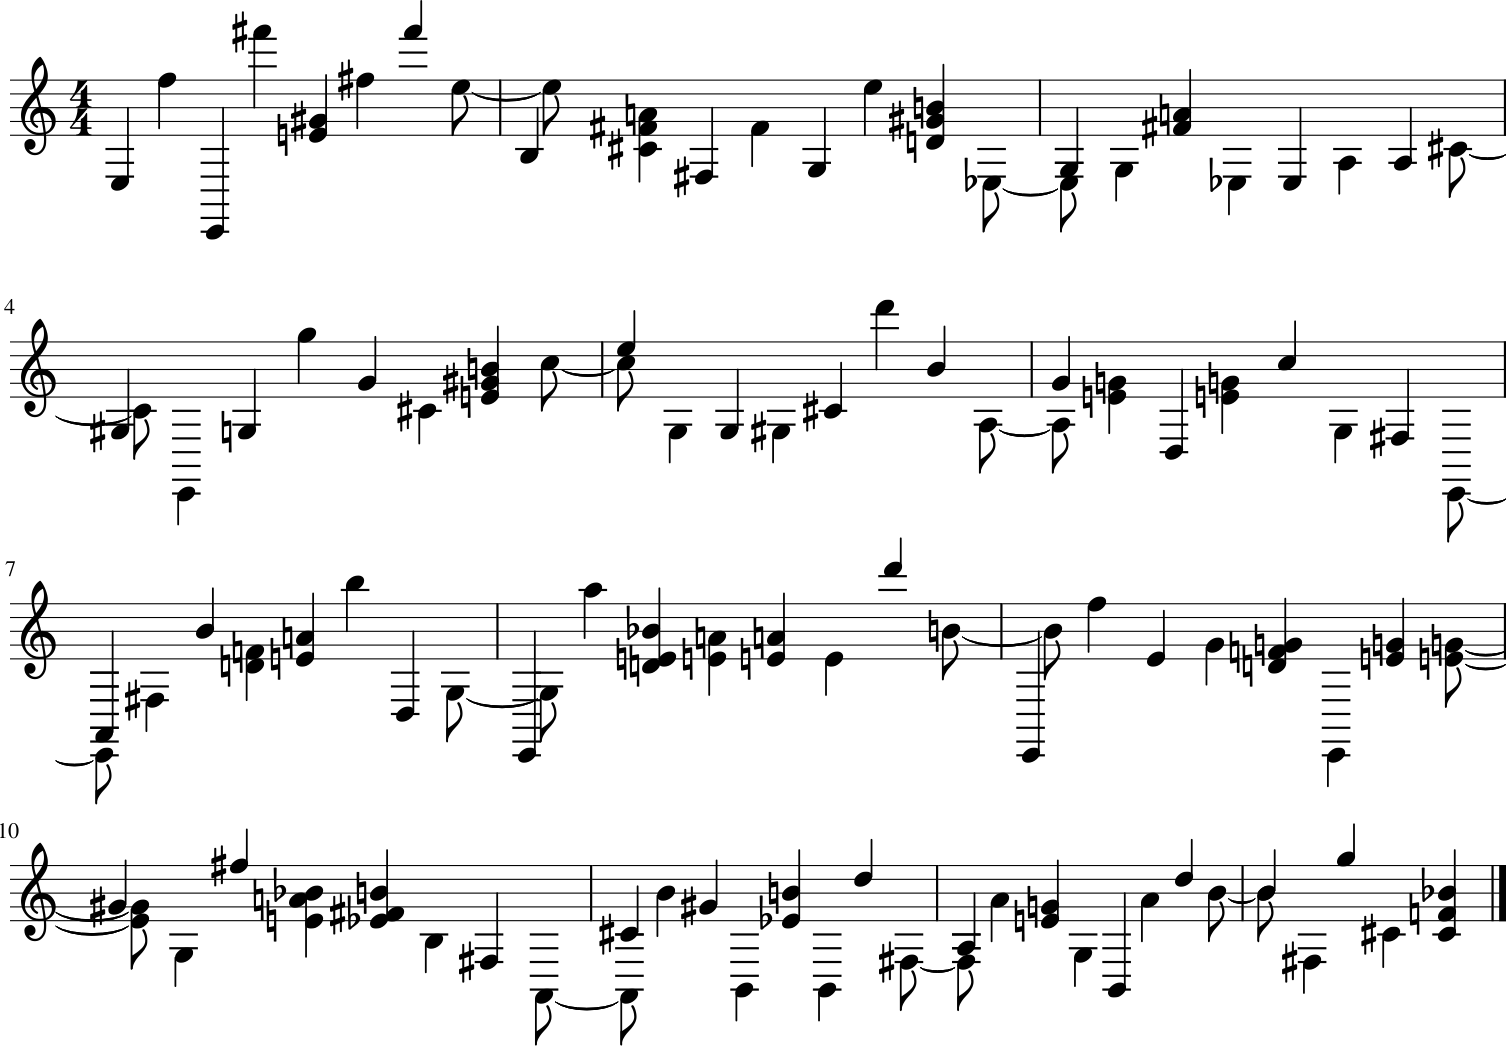

In [12]:
midi_stream.show()

Finally, we can also extract into a midi format.

In [13]:
midi_stream.write('midi', fp=r'D:\Documents\Music generation project\output\test_outpu_custom.mid')

'D:\\Documents\\Music generation project\\output\\test_outpu_custom.mid'